<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Capstone Project - Predicting COVID-19 Mortality & Severity  - Notebook 2  (Modelling to Predict 'Death')

This notebook outlines the feature selection and modelling for prediction of COVID-19 deaths.

In [773]:
# Import Libraries
import pandas as pd
import numpy as np
from textwrap import wrap

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style(style='white')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier

import itertools
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [640]:
# Import data
mortality = pd.read_csv(r'/Users/gaylecferguson/Data/Capstone_Project/mortality_clean.csv',header=0)
print(mortality.shape)
mortality.head()

(4711, 77)


,Unnamed: 0,LOS,Death,AgeGroup,Severity,Black,White,Asian,Latino,MI,...,AST>50,ALT>100,ALT>50,WBC<4.3>10.8,Lympho<1,Lympho>2,IL6>60,Ferritin>1000,CrctProtein>20,Procalcitonin>2
0,0,1,0,>80,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1,>60,7,0,1,0,0,0,...,1,0,0,1,1,0,0,0,0,0
2,2,2,1,>80,7,0,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0
3,3,15,0,>70,9,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,1
4,4,9,0,>70,7,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [641]:
# Dropped 'Unnamed: 0' column generated by the csv file, and 'AgeGroup', which contains strings and is effectively
  # replaced by 'AgeScore'
mortality.drop(['Unnamed: 0','AgeGroup'], axis=1, inplace=True)
print(mortality.shape)
mortality.columns

(4711, 75)


Index(['LOS', 'Death', 'Severity', 'Black', 'White', 'Asian', 'Latino', 'MI',
       'PVD', 'CHF', 'CVD', 'DEMENT', 'COPD', 'DMcompl', 'DMsimple',
       'RenalDis', 'AllCNS', 'PureCNS', 'Stroke', 'Seizure', 'OldSyncope',
       'OldOtherNeuro', 'OtherBrnLsn', 'Age', 'AgeScore', 'O2Sat', 'Temp',
       'Temp>38', 'MAP', 'MAP<70', 'DDimer', 'DDimer>3', 'PltsScore', 'INR',
       'BUN', 'Creatinine', 'CrtnScore', 'Sodium', 'Glucose', 'AST', 'ALT',
       'WBC', 'Lympho', 'IL6', 'Ferritin', 'CrctProtein', 'CrctProtein>10',
       'Procalcitonin', 'Procalcitonin>0.1', 'Troponin', 'Troponin>0.1',
       'PVDcompressed', 'BUN>30', 'BUN>100', 'O2Sat<94', 'O2Sat<90',
       'Temp<=36', 'Temp>39', 'DDimer>17', 'INR>1.2', 'Sodium130<>145',
       'Sodium>155', 'Glucose<60>140', 'Glucose>200', 'AST>100', 'AST>50',
       'ALT>100', 'ALT>50', 'WBC<4.3>10.8', 'Lympho<1', 'Lympho>2', 'IL6>60',
       'Ferritin>1000', 'CrctProtein>20', 'Procalcitonin>2'],
      dtype='object')

In [642]:
# Remove > and <  and = from column names because these are throwing errors in some of the models

mortality.rename(columns={'Temp>38':'Temp_over38', 'MAP<70':'MAP_under70', 'DDimer>3':'DDimer_over3', 
                         'CrctProtein>10':'CrctProtein_over10', 'Procalcitonin>0.1':'Procalcitonin_over0.1',
                         'Troponin>0.1':'Troponin_over0.1', 'BUN>30':'BUN_over30', 'BUN>100':'BUN_over100',
                          'O2Sat<94':'O2Sat_under94', 'O2Sat<90':'O2Sat_under90', 'Temp<=36':'Temp_isorunder36', 
                         'Temp>39':'Temp_over39', 'DDimer>17':'DDimer_over17', 'INR>1.2':'INR_over1.2', 
                         'Sodium130<>145':'Sodium_betw130and145', 'Sodium>155':'Sodium_over155', 
                         'Glucose<60>140':'Glucose_under60_over140', 'Glucose>200':'Glucose_over200', 
                          'AST>100':'AST_over100', 'AST>50':'AST_over50', 'ALT>100':'ALT_over100', 
                          'ALT>50':'ALT_over50', 'WBC<4.3>10.8':'WBCunder4.3_over10.8', 'Lympho<1':'Lympho_under1', 
                          'Lympho>2':'Lympho_over2', 'IL6>60':'IL6_over60', 'Ferritin>1000':'Ferritin_over1000', 
                          'CrctProtein>20':'CrctProtein_over20', 'Procalcitonin>2':'Procalcitonin_over2'}, inplace=True)

In [663]:
# Want to reduce the number of categories for 'Severity' to improve the model.
mortality[['Severity']].value_counts()

Severity
3           806
2           729
4           728
5           554
1           537
6           395
0           390
7           305
8           155
9            75
10           27
11           10
dtype: int64

In [664]:
# Need to convert 'object' to numeric (it was originally showing as 'object', 
  # but now shows as 'int64'), even when I reimport the spreadsheet
mortality['Severity'] = pd.to_numeric(mortality['Severity'])
print(mortality[['Severity']].dtypes)

Severity    int64
dtype: object


In [665]:
# Created 4 categories from 12 for 'Severity'
mortality['Severity'] = np.where((mortality['Severity'] <= 2), 1, mortality['Severity'])
mortality['Severity'] = np.where((mortality['Severity'] == 3), 2, mortality['Severity'])

In [667]:
# Created 4 categories from 12 for 'Severity'
mortality['Severity'] = np.where((mortality['Severity'] == 4), 2, mortality['Severity'])
mortality['Severity'] = np.where((mortality['Severity'] == 5), 2, mortality['Severity'])
mortality['Severity'] = np.where((mortality['Severity'] == 6), 3, mortality['Severity'])
mortality['Severity'] = np.where((mortality['Severity'] == 7), 3, mortality['Severity'])
mortality['Severity'] = np.where((mortality['Severity'] == 8), 3, mortality['Severity'])
mortality['Severity'] = np.where((mortality['Severity'] == 9), 4, mortality['Severity'])
mortality['Severity'] = np.where((mortality['Severity'] == 10), 4, mortality['Severity'])
mortality['Severity'] = np.where((mortality['Severity'] == 11), 4, mortality['Severity'])

In [668]:
mortality[['Severity']].value_counts()

Severity
2           2200
1           1656
3            855
dtype: int64

In [669]:
# Exported cleaned data to .csv
mortality.to_csv('mortality_clean_2.csv')

In [670]:
# Prepare the data
X = mortality.drop(['Death'], axis=1)
y = mortality['Death']

## 2.1. Test/Train/Validation Split

In [671]:
# Partioned the data into train, validation and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (2826, 74)
y_train:  (2826,)
X_val:  (942, 74)
y_val:  (942,)
X_test:  (943, 74)
y_test:  (943,)


In [672]:
# Scale the X data
  # Only want to scale the float data, not the catagorical data
     # LOS has many integer values so will treat is as a float (as with age) and scale it. 

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train[['LOS','Age','O2Sat','Temp','MAP','DDimer','INR', 'BUN', 'Creatinine', 'Sodium', 'Glucose', 'AST', 
        'ALT', 'WBC', 'Lympho', 'IL6', 'Ferritin', 'CrctProtein','Procalcitonin',
        'Troponin']] = scaler.fit_transform(X_train[['LOS','Age','O2Sat','Temp','MAP','DDimer','INR', 'BUN', 
                                                     'Creatinine', 'Sodium', 'Glucose', 'AST', 'ALT', 'WBC', 
                                                     'Lympho', 'IL6', 'Ferritin', 'CrctProtein','Procalcitonin',
                                                     'Troponin']])

X_val[['LOS','Age','O2Sat','Temp','MAP','DDimer','INR', 'BUN', 'Creatinine', 'Sodium', 'Glucose', 'AST', 
        'ALT', 'WBC', 'Lympho', 'IL6', 'Ferritin', 'CrctProtein','Procalcitonin',
        'Troponin']] = scaler.transform(X_val[['LOS','Age','O2Sat','Temp','MAP','DDimer','INR', 'BUN', 
                                                   'Creatinine', 'Sodium', 'Glucose', 'AST', 'ALT', 'WBC', 'Lympho', 
                                                   'IL6', 'Ferritin', 'CrctProtein','Procalcitonin','Troponin']])

X_test[['LOS','Age','O2Sat','Temp','MAP','DDimer','INR', 'BUN', 'Creatinine', 'Sodium', 'Glucose', 'AST', 
        'ALT', 'WBC', 'Lympho', 'IL6', 'Ferritin', 'CrctProtein','Procalcitonin',
        'Troponin']] = scaler.transform(X_test[['LOS','Age','O2Sat','Temp','MAP','DDimer','INR', 'BUN', 
                                                   'Creatinine', 'Sodium', 'Glucose', 'AST', 'ALT', 'WBC', 'Lympho', 
                                                   'IL6', 'Ferritin', 'CrctProtein','Procalcitonin','Troponin']])

In [673]:
# Checking the scaled features

X_train[['LOS','Age','O2Sat','Temp','MAP','DDimer','INR', 'BUN', 'Creatinine', 'Sodium', 'Glucose', 'AST', 
        'ALT', 'WBC', 'Lympho', 'IL6', 'Ferritin', 'CrctProtein','Procalcitonin',
        'Troponin']].head()

,LOS,Age,O2Sat,Temp,MAP,DDimer,INR,BUN,Creatinine,Sodium,Glucose,AST,ALT,WBC,Lympho,IL6,Ferritin,CrctProtein,Procalcitonin,Troponin
4476,-0.606547,-1.036751,0.355856,-1.011404,0.773560,-0.310606,0.069245,0.495459,-0.507137,1.472478,-0.425790,-0.131223,-0.268932,-0.083486,-0.163719,-0.052601,-0.059364,-0.653287,-0.247466,-0.144942
2297,0.106770,1.110059,0.233499,-0.770989,-0.382057,3.122543,0.556272,3.657945,0.382927,4.185938,0.222723,-0.144718,-0.295503,0.204186,-0.034083,-0.051228,-0.033988,-1.037563,-0.247466,-0.080548
529,-0.606547,1.766029,0.478212,-0.770989,1.723570,0.793973,-0.222971,0.356450,-0.263337,-0.562617,1.012216,-0.180704,-0.189221,0.601449,0.009129,-0.048025,-0.119632,-0.326652,-0.247466,-0.016155
3327,-0.749211,0.096287,-0.133570,0.813564,0.051454,-0.366581,-0.125566,-0.338594,-0.360083,0.387094,-0.604366,-0.126725,-0.136080,-0.193076,-0.098901,-0.038912,0.013944,-0.134513,-0.231112,-0.144942
2522,1.533406,1.110059,0.722926,-0.465007,0.071891,-0.500922,-0.222971,-0.755621,-0.402651,-2.190692,0.711457,-0.099736,-0.100653,-0.645133,0.246795,-0.060894,-0.336385,-1.133642,-0.247466,-0.144942


In [674]:
# Checking the full dataset

X_train.head(3)

,LOS,Severity,Black,White,Asian,Latino,MI,PVD,CHF,CVD,...,AST_over50,ALT_over100,ALT_over50,WBCunder4.3_over10.8,Lympho_under1,Lympho_over2,IL6_over60,Ferritin_over1000,CrctProtein_over20,Procalcitonin_over2
4476,-0.606547,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2297,0.106770,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
529,-0.606547,2,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


## 2.2. Dimension Reduction - Principal Component Analysis

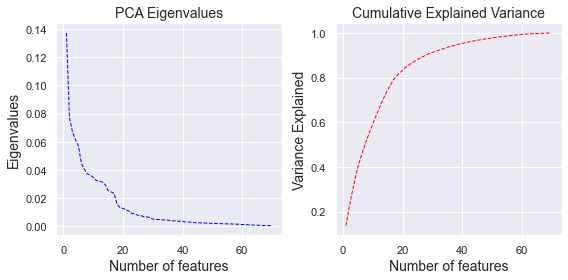

In [675]:
# Plot scree plot to choose principal components

pca = PCA(n_components=70, copy=True, whiten=True)

X_train_pca = pca.fit_transform(X_train)

PC_values = np.arange(pca.n_components_) + 1
expvar = pca.explained_variance_ratio_
cumexpvar = pca.explained_variance_ratio_.cumsum()
sns.set_style(style='darkgrid')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.plot(PC_values, expvar, '--', linewidth=1, color='blue')
ax2.plot(PC_values, cumexpvar, '--', linewidth=1, color='red')
#plt.hist(expvar, bins=70, color='blue')
ax1.set_title('PCA Eigenvalues',fontsize=14)
ax1.set_xlabel('Number of features', fontsize=14)
ax1.set_ylabel('Eigenvalues', fontsize=14)
ax2.set_title('Cumulative Explained Variance',fontsize=14)
ax2.set_xlabel('Number of features', fontsize=14)
ax2.set_ylabel('Variance Explained', fontsize=14)

plt.tight_layout()
plt.show()

Seventy principal components explain 99.9%% of the variance in the dataset. The decomposition rate of the curves show that in the case of this dataset, although the first 10 principal components explain the majority of the variation, a large dimension reduction will still sacrifice a lot of the explained variance. 

In [676]:
# Carried out PCA to select 60 principal components

pca = PCA(n_components=60, copy=True, whiten=True)

In [677]:
# Transformed the validation and test datasets

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [678]:
pca.explained_variance_ratio_

array([0.14, 0.08, 0.07, 0.06, 0.06, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [679]:
# Cumulative explained variance
pca.explained_variance_ratio_.cumsum()

array([0.14, 0.21, 0.28, 0.34, 0.4 , 0.45, 0.49, 0.52, 0.56, 0.59, 0.63,
       0.66, 0.69, 0.72, 0.74, 0.77, 0.79, 0.81, 0.82, 0.83, 0.84, 0.86,
       0.86, 0.87, 0.88, 0.89, 0.89, 0.9 , 0.91, 0.91, 0.92, 0.92, 0.93,
       0.93, 0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.96, 0.96, 0.96, 0.96,
       0.97, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.99,
       0.99, 0.99, 0.99, 0.99, 0.99])

## 2.3. Feature Selection - Recursive feature elimination

In [680]:
%%time
# Will use logistic regression as the estimator for recursive feature selection to find the 
  # best short-list of features for predicting 'death'

lr_params = {'penalty':['l2'], 'C':[1,10,100], 'solver':['liblinear','lbfgs']}

logreg = LogisticRegression(tol=0.0001, random_state=1, max_iter=10000)

gs = GridSearchCV(estimator=logreg, param_grid=lr_params)

gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.8290897151255512
CPU times: user 5.26 s, sys: 1.17 s, total: 6.43 s
Wall time: 917 ms


In [681]:
%%time
logreg = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, random_state=1, solver='liblinear', max_iter=10000)
rfe = RFE(estimator=logreg,n_features_to_select=74)
rfe.fit_transform(X_train, y_train)

CPU times: user 76.8 ms, sys: 24.6 ms, total: 101 ms
Wall time: 21.6 ms


array([[-0.61,  1.  ,  0.  , ...,  1.  ,  0.  ,  0.  ],
       [ 0.11,  3.  ,  1.  , ...,  1.  ,  0.  ,  0.  ],
       [-0.61,  2.  ,  1.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [-0.04,  2.  ,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [-0.89,  2.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 1.53,  2.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [682]:
# Print Score
print("Score: ", rfe.score(X_train, y_train))

# Find Top 10 Features
print("Top 10 features: ", rfe.get_feature_names_out())

Score:  0.8418259023354565
Top 10 features:  ['LOS' 'Severity' 'Black' 'White' 'Asian' 'Latino' 'MI' 'PVD' 'CHF' 'CVD'
 'DEMENT' 'COPD' 'DMcompl' 'DMsimple' 'RenalDis' 'AllCNS' 'PureCNS'
 'Stroke' 'Seizure' 'OldSyncope' 'OldOtherNeuro' 'OtherBrnLsn' 'Age'
 'AgeScore' 'O2Sat' 'Temp' 'Temp_over38' 'MAP' 'MAP_under70' 'DDimer'
 'DDimer_over3' 'PltsScore' 'INR' 'BUN' 'Creatinine' 'CrtnScore' 'Sodium'
 'Glucose' 'AST' 'ALT' 'WBC' 'Lympho' 'IL6' 'Ferritin' 'CrctProtein'
 'CrctProtein_over10' 'Procalcitonin' 'Procalcitonin_over0.1' 'Troponin'
 'Troponin_over0.1' 'PVDcompressed' 'BUN_over30' 'BUN_over100'
 'O2Sat_under94' 'O2Sat_under90' 'Temp_isorunder36' 'Temp_over39'
 'DDimer_over17' 'INR_over1.2' 'Sodium_betw130and145' 'Sodium_over155'
 'Glucose_under60_over140' 'Glucose_over200' 'AST_over100' 'AST_over50'
 'ALT_over100' 'ALT_over50' 'WBCunder4.3_over10.8' 'Lympho_under1'
 'Lympho_over2' 'IL6_over60' 'Ferritin_over1000' 'CrctProtein_over20'
 'Procalcitonin_over2']


In [683]:
# Print Score
print("Score: ", rfe.score(X_train, y_train))

# Find Top 15 Features
print("Top 15 features: ", rfe.get_feature_names_out())

Score:  0.8418259023354565
Top 15 features:  ['LOS' 'Severity' 'Black' 'White' 'Asian' 'Latino' 'MI' 'PVD' 'CHF' 'CVD'
 'DEMENT' 'COPD' 'DMcompl' 'DMsimple' 'RenalDis' 'AllCNS' 'PureCNS'
 'Stroke' 'Seizure' 'OldSyncope' 'OldOtherNeuro' 'OtherBrnLsn' 'Age'
 'AgeScore' 'O2Sat' 'Temp' 'Temp_over38' 'MAP' 'MAP_under70' 'DDimer'
 'DDimer_over3' 'PltsScore' 'INR' 'BUN' 'Creatinine' 'CrtnScore' 'Sodium'
 'Glucose' 'AST' 'ALT' 'WBC' 'Lympho' 'IL6' 'Ferritin' 'CrctProtein'
 'CrctProtein_over10' 'Procalcitonin' 'Procalcitonin_over0.1' 'Troponin'
 'Troponin_over0.1' 'PVDcompressed' 'BUN_over30' 'BUN_over100'
 'O2Sat_under94' 'O2Sat_under90' 'Temp_isorunder36' 'Temp_over39'
 'DDimer_over17' 'INR_over1.2' 'Sodium_betw130and145' 'Sodium_over155'
 'Glucose_under60_over140' 'Glucose_over200' 'AST_over100' 'AST_over50'
 'ALT_over100' 'ALT_over50' 'WBCunder4.3_over10.8' 'Lympho_under1'
 'Lympho_over2' 'IL6_over60' 'Ferritin_over1000' 'CrctProtein_over20'
 'Procalcitonin_over2']


In [684]:
# Print Score
print("Score: ", rfe.score(X_train, y_train))

# Find Top 20 Features
print("Top 20 features: ", rfe.get_feature_names_out())

Score:  0.8418259023354565
Top 20 features:  ['LOS' 'Severity' 'Black' 'White' 'Asian' 'Latino' 'MI' 'PVD' 'CHF' 'CVD'
 'DEMENT' 'COPD' 'DMcompl' 'DMsimple' 'RenalDis' 'AllCNS' 'PureCNS'
 'Stroke' 'Seizure' 'OldSyncope' 'OldOtherNeuro' 'OtherBrnLsn' 'Age'
 'AgeScore' 'O2Sat' 'Temp' 'Temp_over38' 'MAP' 'MAP_under70' 'DDimer'
 'DDimer_over3' 'PltsScore' 'INR' 'BUN' 'Creatinine' 'CrtnScore' 'Sodium'
 'Glucose' 'AST' 'ALT' 'WBC' 'Lympho' 'IL6' 'Ferritin' 'CrctProtein'
 'CrctProtein_over10' 'Procalcitonin' 'Procalcitonin_over0.1' 'Troponin'
 'Troponin_over0.1' 'PVDcompressed' 'BUN_over30' 'BUN_over100'
 'O2Sat_under94' 'O2Sat_under90' 'Temp_isorunder36' 'Temp_over39'
 'DDimer_over17' 'INR_over1.2' 'Sodium_betw130and145' 'Sodium_over155'
 'Glucose_under60_over140' 'Glucose_over200' 'AST_over100' 'AST_over50'
 'ALT_over100' 'ALT_over50' 'WBCunder4.3_over10.8' 'Lympho_under1'
 'Lympho_over2' 'IL6_over60' 'Ferritin_over1000' 'CrctProtein_over20'
 'Procalcitonin_over2']


In [685]:
# Print Score
print("Score: ", rfe.score(X_train, y_train))

# Find Top 30 Features
print("Top 30 features: ", rfe.get_feature_names_out())

Score:  0.8418259023354565
Top 30 features:  ['LOS' 'Severity' 'Black' 'White' 'Asian' 'Latino' 'MI' 'PVD' 'CHF' 'CVD'
 'DEMENT' 'COPD' 'DMcompl' 'DMsimple' 'RenalDis' 'AllCNS' 'PureCNS'
 'Stroke' 'Seizure' 'OldSyncope' 'OldOtherNeuro' 'OtherBrnLsn' 'Age'
 'AgeScore' 'O2Sat' 'Temp' 'Temp_over38' 'MAP' 'MAP_under70' 'DDimer'
 'DDimer_over3' 'PltsScore' 'INR' 'BUN' 'Creatinine' 'CrtnScore' 'Sodium'
 'Glucose' 'AST' 'ALT' 'WBC' 'Lympho' 'IL6' 'Ferritin' 'CrctProtein'
 'CrctProtein_over10' 'Procalcitonin' 'Procalcitonin_over0.1' 'Troponin'
 'Troponin_over0.1' 'PVDcompressed' 'BUN_over30' 'BUN_over100'
 'O2Sat_under94' 'O2Sat_under90' 'Temp_isorunder36' 'Temp_over39'
 'DDimer_over17' 'INR_over1.2' 'Sodium_betw130and145' 'Sodium_over155'
 'Glucose_under60_over140' 'Glucose_over200' 'AST_over100' 'AST_over50'
 'ALT_over100' 'ALT_over50' 'WBCunder4.3_over10.8' 'Lympho_under1'
 'Lympho_over2' 'IL6_over60' 'Ferritin_over1000' 'CrctProtein_over20'
 'Procalcitonin_over2']


In [686]:
# Print Score
print("Score: ", rfe.score(X_train, y_train))

# Find Top 40 Features
print("Top 40 features: ", rfe.get_feature_names_out())

Score:  0.8418259023354565
Top 40 features:  ['LOS' 'Severity' 'Black' 'White' 'Asian' 'Latino' 'MI' 'PVD' 'CHF' 'CVD'
 'DEMENT' 'COPD' 'DMcompl' 'DMsimple' 'RenalDis' 'AllCNS' 'PureCNS'
 'Stroke' 'Seizure' 'OldSyncope' 'OldOtherNeuro' 'OtherBrnLsn' 'Age'
 'AgeScore' 'O2Sat' 'Temp' 'Temp_over38' 'MAP' 'MAP_under70' 'DDimer'
 'DDimer_over3' 'PltsScore' 'INR' 'BUN' 'Creatinine' 'CrtnScore' 'Sodium'
 'Glucose' 'AST' 'ALT' 'WBC' 'Lympho' 'IL6' 'Ferritin' 'CrctProtein'
 'CrctProtein_over10' 'Procalcitonin' 'Procalcitonin_over0.1' 'Troponin'
 'Troponin_over0.1' 'PVDcompressed' 'BUN_over30' 'BUN_over100'
 'O2Sat_under94' 'O2Sat_under90' 'Temp_isorunder36' 'Temp_over39'
 'DDimer_over17' 'INR_over1.2' 'Sodium_betw130and145' 'Sodium_over155'
 'Glucose_under60_over140' 'Glucose_over200' 'AST_over100' 'AST_over50'
 'ALT_over100' 'ALT_over50' 'WBCunder4.3_over10.8' 'Lympho_under1'
 'Lympho_over2' 'IL6_over60' 'Ferritin_over1000' 'CrctProtein_over20'
 'Procalcitonin_over2']


In [687]:
# Print Score
print("Score: ", rfe.score(X_train, y_train))

# Find Top 50 Features
print("Top 50 features: ", rfe.get_feature_names_out())

Score:  0.8418259023354565
Top 50 features:  ['LOS' 'Severity' 'Black' 'White' 'Asian' 'Latino' 'MI' 'PVD' 'CHF' 'CVD'
 'DEMENT' 'COPD' 'DMcompl' 'DMsimple' 'RenalDis' 'AllCNS' 'PureCNS'
 'Stroke' 'Seizure' 'OldSyncope' 'OldOtherNeuro' 'OtherBrnLsn' 'Age'
 'AgeScore' 'O2Sat' 'Temp' 'Temp_over38' 'MAP' 'MAP_under70' 'DDimer'
 'DDimer_over3' 'PltsScore' 'INR' 'BUN' 'Creatinine' 'CrtnScore' 'Sodium'
 'Glucose' 'AST' 'ALT' 'WBC' 'Lympho' 'IL6' 'Ferritin' 'CrctProtein'
 'CrctProtein_over10' 'Procalcitonin' 'Procalcitonin_over0.1' 'Troponin'
 'Troponin_over0.1' 'PVDcompressed' 'BUN_over30' 'BUN_over100'
 'O2Sat_under94' 'O2Sat_under90' 'Temp_isorunder36' 'Temp_over39'
 'DDimer_over17' 'INR_over1.2' 'Sodium_betw130and145' 'Sodium_over155'
 'Glucose_under60_over140' 'Glucose_over200' 'AST_over100' 'AST_over50'
 'ALT_over100' 'ALT_over50' 'WBCunder4.3_over10.8' 'Lympho_under1'
 'Lympho_over2' 'IL6_over60' 'Ferritin_over1000' 'CrctProtein_over20'
 'Procalcitonin_over2']


In [688]:
# Print Score
print("Score: ", rfe.score(X_train, y_train))

# Find Top 60 Features
print("Top 60 features: ", rfe.get_feature_names_out())

Score:  0.8418259023354565
Top 60 features:  ['LOS' 'Severity' 'Black' 'White' 'Asian' 'Latino' 'MI' 'PVD' 'CHF' 'CVD'
 'DEMENT' 'COPD' 'DMcompl' 'DMsimple' 'RenalDis' 'AllCNS' 'PureCNS'
 'Stroke' 'Seizure' 'OldSyncope' 'OldOtherNeuro' 'OtherBrnLsn' 'Age'
 'AgeScore' 'O2Sat' 'Temp' 'Temp_over38' 'MAP' 'MAP_under70' 'DDimer'
 'DDimer_over3' 'PltsScore' 'INR' 'BUN' 'Creatinine' 'CrtnScore' 'Sodium'
 'Glucose' 'AST' 'ALT' 'WBC' 'Lympho' 'IL6' 'Ferritin' 'CrctProtein'
 'CrctProtein_over10' 'Procalcitonin' 'Procalcitonin_over0.1' 'Troponin'
 'Troponin_over0.1' 'PVDcompressed' 'BUN_over30' 'BUN_over100'
 'O2Sat_under94' 'O2Sat_under90' 'Temp_isorunder36' 'Temp_over39'
 'DDimer_over17' 'INR_over1.2' 'Sodium_betw130and145' 'Sodium_over155'
 'Glucose_under60_over140' 'Glucose_over200' 'AST_over100' 'AST_over50'
 'ALT_over100' 'ALT_over50' 'WBCunder4.3_over10.8' 'Lympho_under1'
 'Lympho_over2' 'IL6_over60' 'Ferritin_over1000' 'CrctProtein_over20'
 'Procalcitonin_over2']


In [689]:
# Print Score
print("Score: ", rfe.score(X_train, y_train))

# Find Top 70 Features
print("Top 70 features: ", rfe.get_feature_names_out())

Score:  0.8418259023354565
Top 70 features:  ['LOS' 'Severity' 'Black' 'White' 'Asian' 'Latino' 'MI' 'PVD' 'CHF' 'CVD'
 'DEMENT' 'COPD' 'DMcompl' 'DMsimple' 'RenalDis' 'AllCNS' 'PureCNS'
 'Stroke' 'Seizure' 'OldSyncope' 'OldOtherNeuro' 'OtherBrnLsn' 'Age'
 'AgeScore' 'O2Sat' 'Temp' 'Temp_over38' 'MAP' 'MAP_under70' 'DDimer'
 'DDimer_over3' 'PltsScore' 'INR' 'BUN' 'Creatinine' 'CrtnScore' 'Sodium'
 'Glucose' 'AST' 'ALT' 'WBC' 'Lympho' 'IL6' 'Ferritin' 'CrctProtein'
 'CrctProtein_over10' 'Procalcitonin' 'Procalcitonin_over0.1' 'Troponin'
 'Troponin_over0.1' 'PVDcompressed' 'BUN_over30' 'BUN_over100'
 'O2Sat_under94' 'O2Sat_under90' 'Temp_isorunder36' 'Temp_over39'
 'DDimer_over17' 'INR_over1.2' 'Sodium_betw130and145' 'Sodium_over155'
 'Glucose_under60_over140' 'Glucose_over200' 'AST_over100' 'AST_over50'
 'ALT_over100' 'ALT_over50' 'WBCunder4.3_over10.8' 'Lympho_under1'
 'Lympho_over2' 'IL6_over60' 'Ferritin_over1000' 'CrctProtein_over20'
 'Procalcitonin_over2']


In [690]:
# Print Score
print("Score: ", rfe.score(X_train, y_train))

# Find Top 74 Features
print("Top 74 features: ", rfe.get_feature_names_out())

Score:  0.8418259023354565
Top 74 features:  ['LOS' 'Severity' 'Black' 'White' 'Asian' 'Latino' 'MI' 'PVD' 'CHF' 'CVD'
 'DEMENT' 'COPD' 'DMcompl' 'DMsimple' 'RenalDis' 'AllCNS' 'PureCNS'
 'Stroke' 'Seizure' 'OldSyncope' 'OldOtherNeuro' 'OtherBrnLsn' 'Age'
 'AgeScore' 'O2Sat' 'Temp' 'Temp_over38' 'MAP' 'MAP_under70' 'DDimer'
 'DDimer_over3' 'PltsScore' 'INR' 'BUN' 'Creatinine' 'CrtnScore' 'Sodium'
 'Glucose' 'AST' 'ALT' 'WBC' 'Lympho' 'IL6' 'Ferritin' 'CrctProtein'
 'CrctProtein_over10' 'Procalcitonin' 'Procalcitonin_over0.1' 'Troponin'
 'Troponin_over0.1' 'PVDcompressed' 'BUN_over30' 'BUN_over100'
 'O2Sat_under94' 'O2Sat_under90' 'Temp_isorunder36' 'Temp_over39'
 'DDimer_over17' 'INR_over1.2' 'Sodium_betw130and145' 'Sodium_over155'
 'Glucose_under60_over140' 'Glucose_over200' 'AST_over100' 'AST_over50'
 'ALT_over100' 'ALT_over50' 'WBCunder4.3_over10.8' 'Lympho_under1'
 'Lympho_over2' 'IL6_over60' 'Ferritin_over1000' 'CrctProtein_over20'
 'Procalcitonin_over2']


In [691]:
index=['Accuracy Score (LogReg)','Features']
columns=['Top Feature','Top 2 Features','Top 3 Features','Top 4 Features','Top 5 Features','Top 6 Features',
       'Top 7 Features', 'Top 8 Features','Top 9 Features','Top 10 Features','Top 15 Features','Top 20 Features',
       'Top 30 Features', 'Top 40 Features','Top 50 Features','Top 60 Features','Top 70 Features','All Features']
scores=[0.8110,0.8110,0.8124,0.8125,0.8163,0.8153,0.8149,0.8142,0.8146,0.8145,0.8297,0.8347,0.8418,0.8379,0.8415,0.8425,0.8418,0.8422]
features=['MAP<70',
          'MAP<70, Stroke',
          'MAP<70, Stroke, O2Sat<90',
          'MAP<70, Stroke, O2Sat<90, OldSyncope',
          'MAP<70, Stroke, O2Sat<90, OldSyncope, Age',
          'MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDimer>17',
          'MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDimer>17, Asian',
          'MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDimer>17, Asian, AllCNS',
          'MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDimer>17, Asian, AllCNS, Troponin',
          'MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDimer>17, Asian, AllCNS, Troponin, OtherBrnLsn', 
          'ND','ND','ND','ND','ND','ND','ND','ND']
data=np.array([scores,features])
df=pd.DataFrame(data,index=index, columns=columns)  
df = df.transpose() 
df['Accuracy Score (LogReg)'] =  df['Accuracy Score (LogReg)'].astype(np.float16)
df       

,Accuracy Score (LogReg),Features
Top Feature,0.811035,MAP<70
Top 2 Features,0.811035,"MAP<70, Stroke"
Top 3 Features,0.812500,"MAP<70, Stroke, O2Sat<90"
Top 4 Features,0.812500,"MAP<70, Stroke, O2Sat<90, OldSyncope"
Top 5 Features,0.816406,"MAP<70, Stroke, O2Sat<90, OldSyncope, Age"
Top 6 Features,0.815430,"MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDi..."
Top 7 Features,0.814941,"MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDi..."
Top 8 Features,0.813965,"MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDi..."
Top 9 Features,0.814453,"MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDi..."
Top 10 Features,0.814453,"MAP<70, Stroke, O2Sat<90, OldSyncope, Age, DDi..."


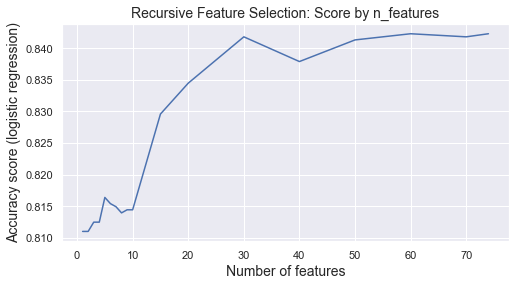

In [692]:
# Plot to see how accuracy score improves as more features are added
  # Accuracy score doesn't improve much beyond the top 30 features

fig, ax = plt.subplots(figsize=(8,4))
x=[1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,74]
y=df['Accuracy Score (LogReg)'].tolist()
sns.set_style("darkgrid")
sns.lineplot(x,y)
ax.set_title("Recursive Feature Selection: Score by n_features", fontsize=14)
ax.set_xlabel("Number of features", fontsize=14)
ax.set_ylabel("Accuracy score (logistic regression)", fontsize=14)
plt.show()

In [693]:
# Created datasets with just the Top 30 features as determined by Recurssive Feature Selection
X_train_top30rfe = X_train[['LOS','Severity','Black','Asian','COPD','DMcompl','RenalDis','AllCNS','Stroke','OldSyncope',
                         'OtherBrnLsn','Age','MAP','MAP_under70','DDimer','CrctProtein','CrctProtein_over10','Procalcitonin',
                         'Troponin','PVDcompressed','BUN_over100','O2Sat_under90','DDimer_over17','Sodium_betw130and145',
                         'Sodium_over155','Glucose_under60_over140','Glucose_over200','AST_over50','ALT_over50','CrctProtein_over20']]

X_val_top30rfe = X_val[['LOS','Severity','Black','Asian','COPD','DMcompl','RenalDis','AllCNS','Stroke','OldSyncope',
                         'OtherBrnLsn','Age','MAP','MAP_under70','DDimer','CrctProtein','CrctProtein_over10','Procalcitonin',
                         'Troponin','PVDcompressed','BUN_over100','O2Sat_under90','DDimer_over17','Sodium_betw130and145',
                         'Sodium_over155','Glucose_under60_over140','Glucose_over200','AST_over50','ALT_over50','CrctProtein_over20']]

X_test_top30rfe = X_test[['LOS','Severity','Black','Asian','COPD','DMcompl','RenalDis','AllCNS','Stroke','OldSyncope',
                         'OtherBrnLsn','Age','MAP','MAP_under70','DDimer','CrctProtein','CrctProtein_over10','Procalcitonin',
                         'Troponin','PVDcompressed','BUN_over100','O2Sat_under90','DDimer_over17','Sodium_betw130and145',
                         'Sodium_over155','Glucose_under60_over140','Glucose_over200','AST_over50','ALT_over50','CrctProtein_over20']]

In [694]:
# Created datasets with the Top 60 features as determined by Recurssive Feature Selection
X_train_top60rfe = X_train[['LOS','Severity','Black','Asian','Latino','CVD','COPD','DMcompl','DMsimple','RenalDis','AllCNS','Stroke','Seizure',
'OldSyncope','OtherBrnLsn','Age','O2Sat','Temp','Temp_over38','MAP','MAP_under70','DDimer','DDimer_over3','PltsScore','BUN',
'Creatinine','CrtnScore','Sodium','AST','ALT','Lympho','IL6','Ferritin','CrctProtein','CrctProtein_over10','Procalcitonin',
'Procalcitonin_over0.1','Troponin','Troponin_over0.1','PVDcompressed','BUN_over100','O2Sat_under94','O2Sat_under90','Temp_isorunder36','Temp_over39',
'DDimer_over17','INR_over1.2','Sodium_betw130and145','Sodium_over155','Glucose_under60_over140','Glucose_over200','AST_over50','ALT_over100','ALT_over50',
'WBCunder4.3_over10.8','Lympho_over2','IL6_over60','Ferritin_over1000','CrctProtein_over20','Procalcitonin_over2']]

X_val_top60rfe = X_val[['LOS','Severity','Black','Asian','Latino','CVD','COPD','DMcompl','DMsimple','RenalDis','AllCNS','Stroke','Seizure',
'OldSyncope','OtherBrnLsn','Age','O2Sat','Temp','Temp_over38','MAP','MAP_under70','DDimer','DDimer_over3','PltsScore','BUN',
'Creatinine','CrtnScore','Sodium','AST','ALT','Lympho','IL6','Ferritin','CrctProtein','CrctProtein_over10','Procalcitonin',
'Procalcitonin_over0.1','Troponin','Troponin_over0.1','PVDcompressed','BUN_over100','O2Sat_under94','O2Sat_under90','Temp_isorunder36','Temp_over39',
'DDimer_over17','INR_over1.2','Sodium_betw130and145','Sodium_over155','Glucose_under60_over140','Glucose_over200','AST_over50','ALT_over100','ALT_over50',
'WBCunder4.3_over10.8','Lympho_over2','IL6_over60','Ferritin_over1000','CrctProtein_over20','Procalcitonin_over2']]

X_test_top60rfe = X_test[['LOS','Severity','Black','Asian','Latino','CVD','COPD','DMcompl','DMsimple','RenalDis','AllCNS','Stroke','Seizure',
'OldSyncope','OtherBrnLsn','Age','O2Sat','Temp','Temp_over38','MAP','MAP_under70','DDimer','DDimer_over3','PltsScore','BUN',
'Creatinine','CrtnScore','Sodium','AST','ALT','Lympho','IL6','Ferritin','CrctProtein','CrctProtein_over10','Procalcitonin',
'Procalcitonin_over0.1','Troponin','Troponin_over0.1','PVDcompressed','BUN_over100','O2Sat_under94','O2Sat_under90','Temp_isorunder36','Temp_over39',
'DDimer_over17','INR_over1.2','Sodium_betw130and145','Sodium_over155','Glucose_under60_over140','Glucose_over200','AST_over50','ALT_over100','ALT_over50',
'WBCunder4.3_over10.8','Lympho_over2','IL6_over60','Ferritin_over1000','CrctProtein_over20','Procalcitonin_over2']]

In [695]:
# Checking row and column numbers
print("X_train_top30: ", X_train_top30.shape)
print("y_train: ", y_train.shape)
print("X_val_top30: ", X_val_top30.shape)
print("y_val: ", y_val.shape)
print("X_test_top30: ", X_test_top30.shape)
print("y_test: ", y_test.shape)
print("X_train_top60: ", X_train_top60.shape)
print("X_val_top60: ", X_val_top60.shape)
print("X_test_top60: ", X_test_top60.shape)

X_train_top30:  (2826, 30)
y_train:  (2826,)
X_val_top30:  (942, 30)
y_val:  (942,)
X_test_top30:  (943, 30)
y_test:  (943,)
X_train_top60:  (2826, 60)
X_val_top60:  (942, 60)
X_test_top60:  (943, 60)


## 2.4. Feature Selection - Univariate Feature Selection

I wished to compare RFE and Univariate Feature Selection as methods of feature selection, to see which method produced the best result.

In [696]:
# Reimport clean data
mortality = pd.read_csv(r'/Users/gaylecferguson/Data/Capstone_Project/mortality_clean.csv',header=0)
print(mortality.shape)
mortality.head(3)

(4711, 77)


,Unnamed: 0,LOS,Death,AgeGroup,Severity,Black,White,Asian,Latino,MI,...,AST>50,ALT>100,ALT>50,WBC<4.3>10.8,Lympho<1,Lympho>2,IL6>60,Ferritin>1000,CrctProtein>20,Procalcitonin>2
0,0,1,0,>80,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1,>60,7,0,1,0,0,0,...,1,0,0,1,1,0,0,0,0,0
2,2,2,1,>80,7,0,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0


In [697]:
# Scoring by Chi2 only works if there are no negative values.  
# So data needs to be rescaled in order to carry out this analysis
scaler2 = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)

In [698]:
# Prepare the data
X = mortality.drop(['Unnamed: 0','Death','AgeGroup'], axis=1)
y = mortality['Death']

In [699]:
X_scaled = scaler2.fit_transform(X)
#print(scaler2.data_max_)
X_scaled = pd.DataFrame(X_scaled)

In [700]:
# feature extraction
 # Code reference: https://stackoverflow.com/questions/40245277/visualize-feature-selection-in-descending-order-with-selectkbest
skb = SelectKBest(score_func=chi2, k=40)
fit = skb.fit(X_scaled,y)

# summarize scores
np.set_printoptions(precision=2)
#print(fit.scores_)

In [701]:
# Get the indices sorted by most important to least important
indices = np.argsort(fit.scores_)[::-1]

# To get your top 10 feature names
features = []
for i in range(40):
    features.append(X_scaled.columns[indices[i]])
    
indices

array([28, 73, 54, 51, 23, 47, 70, 72,  1, 45, 35, 49, 30, 57, 59, 53, 58,
       46, 64, 52, 29, 63, 60, 71, 15, 68, 16, 50, 33, 22, 44, 27, 62, 17,
        7, 61, 67, 48, 34,  0, 31, 26, 14, 11,  3,  8,  4, 43, 20, 38, 69,
       10, 56, 24, 32, 65, 42, 36,  5, 39, 37,  9,  2, 19, 40, 21,  6, 12,
       18, 66, 55, 25, 13, 41])

In [702]:
# Dataset_4:  Top 30 by Select K Best

X_train_skb30 = X_train[['MAP_under70','Procalcitonin_over2','O2Sat_under90','BUN_over30','AgeScore',
                         'Procalcitonin_over0.1','IL6_over60','CrctProtein_over20','Severity','CrctProtein_over10',
                         'CrtnScore','Troponin_over0.1','DDimer_over3','DDimer_over17','Sodium_betw130and145',
                         'O2Sat_under94','INR_over1.2','Procalcitonin','AST_over50','BUN_over100','DDimer',
                         'AST_over100','Sodium_over155','Ferritin_over1000','AllCNS','Lympho_under1','PureCNS',
                         'PVDcompressed','BUN','Age']]

X_val_skb30 = X_val[['MAP_under70','Procalcitonin_over2','O2Sat_under90','BUN_over30','AgeScore',
                         'Procalcitonin_over0.1','IL6_over60','CrctProtein_over20','Severity','CrctProtein_over10',
                         'CrtnScore','Troponin_over0.1','DDimer_over3','DDimer_over17','Sodium_betw130and145',
                         'O2Sat_under94','INR_over1.2','Procalcitonin','AST_over50','BUN_over100','DDimer',
                         'AST_over100','Sodium_over155','Ferritin_over1000','AllCNS','Lympho_under1','PureCNS',
                         'PVDcompressed','BUN','Age']]

X_test_skb30 = X_test[['MAP_under70','Procalcitonin_over2','O2Sat_under90','BUN_over30','AgeScore',
                         'Procalcitonin_over0.1','IL6_over60','CrctProtein_over20','Severity','CrctProtein_over10',
                         'CrtnScore','Troponin_over0.1','DDimer_over3','DDimer_over17','Sodium_betw130and145',
                         'O2Sat_under94','INR_over1.2','Procalcitonin','AST_over50','BUN_over100','DDimer',
                         'AST_over100','Sodium_over155','Ferritin_over1000','AllCNS','Lympho_under1','PureCNS',
                         'PVDcompressed','BUN','Age']] 

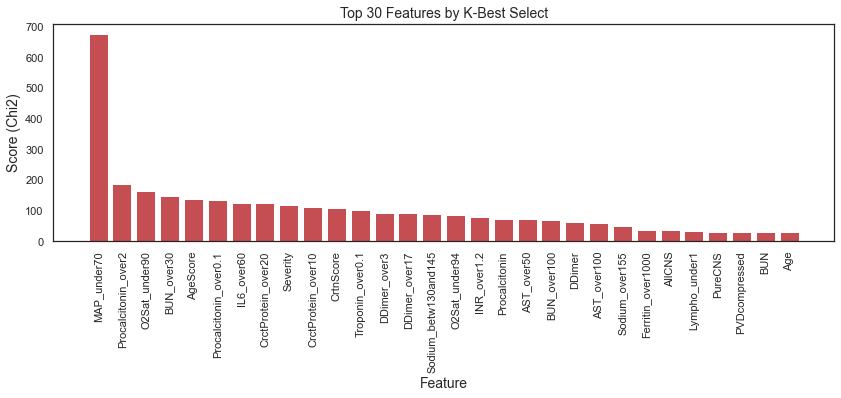

In [748]:
# Retrieved feature names from column indices and created a dataframe

index=['MAP_under70','Procalcitonin_over2','O2Sat_under90','BUN_over30','AgeScore',
                         'Procalcitonin_over0.1','IL6_over60','CrctProtein_over20','Severity','CrctProtein_over10',
                         'CrtnScore','Troponin_over0.1','DDimer_over3','DDimer_over17','Sodium_betw130and145',
                         'O2Sat_under94','INR_over1.2','Procalcitonin','AST_over50','BUN_over100','DDimer',
                         'AST_over100','Sodium_over155','Ferritin_over1000','AllCNS','Lympho_under1','PureCNS',
                         'PVDcompressed','BUN','Age']

scoresDF = pd.DataFrame(fit.scores_[indices[range(30)]],columns=['Scores'], index=index)
#scoresDF = scoresDF.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
#scoresDF = scoresDF.columns({})
    
# Now plot
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(x=scoresDF.index, height=scoresDF.Scores, color='r', align='center')
plt.title("Top 30 Features by K-Best Select",fontsize=14)
plt.xlabel("Feature",fontsize=14)
plt.ylabel("Score (Chi2)",fontsize=14)

plt.tick_params('x',rotation=90)

plt.show()

## 2.5. Modelling

### 2.5.1. Parameter Searches 

I used gridsearchCV or randomsearchCV to find the best parameters for each of the following models:

In [703]:
%%time
# GridsearchCV to find best hyperparameters for the K-NN model

knn_params = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
    'weights': ['uniform','distance'],
    'p': [1,2]
}
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None)
gs = GridSearchCV(estimator=knn, param_grid=knn_params, verbose=1, cv=10, n_jobs=-1)
gs.fit(X_train_pca, y_train)
sorted(gs.cv_results_.keys())

# Print results of gridsearch on K-NN  model
print("Best estimator:", '\t', gs.best_estimator_)
print("Best score:", '\t', '\t', gs.best_score_)
print("Best parameters:", '\t', gs.best_params_)
print("Best scorer:", '\t', '\t', gs.scorer_)
print("No. CV splits:", '\t', '\t', gs.n_splits_)
print("Refit time:", '\t', '\t', gs.refit_time_)
print("Multimetric:", '\t', '\t', gs.multimetric_)
print("Classes:", '\t', '\t', gs.classes_)
print("No. of features:", '\t', gs.n_features_in_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best estimator: 	 KNeighborsClassifier()
Best score: 	 	 0.7813234593890185
Best parameters: 	 {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best scorer: 	 	 <function _passthrough_scorer at 0x7f9a832b7a60>
No. CV splits: 	 	 10
Refit time: 	 	 0.002183198928833008
Multimetric: 	 	 False
Classes: 	 	 [0 1]
No. of features: 	 60
CPU times: user 264 ms, sys: 171 ms, total: 435 ms
Wall time: 5.24 s


In [704]:
%%time
# Find the best hyperparameters for the SVC model with randomsearch 

svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}

svc = SVC(probability=False, tol=0.001, cache_size=200, verbose=False, max_iter=- 1, 
          decision_function_shape='ovr', break_ties=False, random_state=1)
rs = RandomizedSearchCV(estimator=svc, param_distributions=svc_params, n_iter=100, 
                        cv=5, return_train_score=True)
rs.fit(X_train_pca, y_train)

# Print results of randomsearch on SVC model

print("Best estimator:", '\t', rs.best_estimator_)
print("Best score:", '\t', '\t', rs.best_score_)
print("Best parameters:", '\t', rs.best_params_)
print("Best scorer:", '\t', '\t', rs.scorer_)
print("No. CV splits:", '\t', '\t', rs.n_splits_)
print("Refit time:", '\t', '\t', rs.refit_time_)
print("Multimetric:", '\t', '\t', rs.multimetric_)
print("Classes:", '\t', '\t', rs.classes_)
print("No. of features:", '\t', rs.n_features_in_)

Best estimator: 	 SVC(C=100, gamma=0.001, random_state=1)
Best score: 	 	 0.8266105881985052
Best parameters: 	 {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}
Best scorer: 	 	 <function _passthrough_scorer at 0x7f9a832b7a60>
No. CV splits: 	 	 5
Refit time: 	 	 0.42645812034606934
Multimetric: 	 	 False
Classes: 	 	 [0 1]
No. of features: 	 60
CPU times: user 7min 35s, sys: 1.63 s, total: 7min 37s
Wall time: 7min 40s


In [705]:
%%time
# Find the best hyperparameters for the Gaussian Naive Bayes model with gridsearch

param_grid_gnb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GaussianNB() 
gs = GridSearchCV(estimator=gnb, param_grid=param_grid_gnb, verbose=1, cv=10, n_jobs=-1)
gs.fit(X_train_pca, y_train)

# Print results of gridsearch on Gaussian Naive Bayes model

print("Best estimator:", '\t', gs.best_estimator_)
print("Best score:", '\t', '\t', gs.best_score_)
print("Best parameters:", '\t', gs.best_params_)
print("Best scorer:", '\t', '\t', gs.scorer_)
print("No. CV splits:", '\t', '\t', gs.n_splits_)
print("Refit time:", '\t', '\t', gs.refit_time_)
print("Multimetric:", '\t', '\t', gs.multimetric_)
print("Classes:", '\t', '\t', gs.classes_)
print("No. of features:", '\t', gs.n_features_in_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best estimator: 	 GaussianNB(var_smoothing=0.02310129700083159)
Best score: 	 	 0.792287547302208
Best parameters: 	 {'var_smoothing': 0.02310129700083159}
Best scorer: 	 	 <function _passthrough_scorer at 0x7f9a832b7a60>
No. CV splits: 	 	 10
Refit time: 	 	 0.011138916015625
Multimetric: 	 	 False
Classes: 	 	 [0 1]
No. of features: 	 60
CPU times: user 366 ms, sys: 224 ms, total: 590 ms
Wall time: 3.5 s


In [706]:
%%time
# Find the best hyperparameters for the Bernoulli Naive Bayes model with gridsearch

param_grid_bnb = {
    'alpha': np.logspace(0,-9, num=100)
}
bnb = BernoulliNB(binarize=0.0, fit_prior=True, class_prior=None)
gs = GridSearchCV(estimator=bnb, param_grid=param_grid_bnb, verbose=1, cv=10, n_jobs=-1)
gs.fit(X_train_pca, y_train)

# Print results of gridsearch on Bernoulli Naive Bayes model

print("Best estimator:", '\t', gs.best_estimator_)
print("Best score:", '\t', '\t', gs.best_score_)
print("Best parameters:", '\t', gs.best_params_)
print("Best scorer:", '\t', '\t', gs.scorer_)
print("No. CV splits:", '\t', '\t', gs.n_splits_)
print("Refit time:", '\t', '\t', gs.refit_time_)
print("Multimetric:", '\t', '\t', gs.multimetric_)
print("Classes:", '\t', '\t', gs.classes_)
print("No. of features:", '\t', gs.n_features_in_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best estimator: 	 BernoulliNB()
Best score: 	 	 0.7883880911209684
Best parameters: 	 {'alpha': 1.0}
Best scorer: 	 	 <function _passthrough_scorer at 0x7f9a832b7a60>
No. CV splits: 	 	 10
Refit time: 	 	 0.007508039474487305
Multimetric: 	 	 False
Classes: 	 	 [0 1]
No. of features: 	 60
CPU times: user 374 ms, sys: 61.2 ms, total: 436 ms
Wall time: 1.06 s


In [707]:
%%time
# Find the best hyperparameters for the Random Forest model with randomsearch

param_grid_rf = {
    'n_estimators': [50,100,200,400],
    'criterion': ['gini','entropy'],
     'max_depth': [4,6,8,10,12],
     'min_samples_split': [2,4,6],
     'min_samples_leaf': [1,2,4],
     'max_features': ['sqrt',4,6,10,12]
}
rforest = RandomForestClassifier() 
rs = RandomizedSearchCV(estimator=rforest, param_distributions=param_grid_rf, n_iter=100, 
                        cv=5, return_train_score=True)
rs.fit(X_train_pca, y_train)

# Print results of randomsearch on Random Forest model

print("Best estimator:", '\t', rs.best_estimator_)
print("Best score:", '\t', '\t', rs.best_score_)
print("Best parameters:", '\t', rs.best_params_)
print("Best scorer:", '\t', '\t', rs.scorer_)
print("No. CV splits:", '\t', '\t', rs.n_splits_)
print("Refit time:", '\t', '\t', rs.refit_time_)
print("Multimetric:", '\t', '\t', rs.multimetric_)
print("Classes:", '\t', '\t', rs.classes_)
print("No. of features:", '\t', rs.n_features_in_)

Best estimator: 	 RandomForestClassifier(max_depth=10, max_features=12, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=50)
Best score: 	 	 0.8287351074142405
Best parameters: 	 {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 12, 'max_depth': 10, 'criterion': 'gini'}
Best scorer: 	 	 <function _passthrough_scorer at 0x7f9a832b7a60>
No. CV splits: 	 	 5
Refit time: 	 	 0.7293741703033447
Multimetric: 	 	 False
Classes: 	 	 [0 1]
No. of features: 	 60
CPU times: user 12min 29s, sys: 4.08 s, total: 12min 33s
Wall time: 12min 45s


In [708]:
%%time
# Find the best hyperparameters for the XGBoost model with Randomsearch

xgb_params = {
    'n_estimators': [100, 200, 400],
    'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
    'min_child_weight': [1, 2],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'max_depth': [4, 6, 8, 10],
    'gamma': [0, 0.001, 0.01],
    'alpha': [0, 0.5, 1],
    'lambda': [1.0, 1.1, 1.2],
    'subsample': [0.5, 0.75, 1.0]
}

xgb = XGBClassifier(random_state=1)
rs = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params, n_iter=100, 
                        cv=5, return_train_score=True)
rs.fit(X_train_pca, y_train)

# Print results of randomsearch on XGBoost model model

print("Best estimator:", '\t', rs.best_estimator_)
print("Best score:", '\t', '\t', rs.best_score_)
print("Best parameters:", '\t', rs.best_params_)
print("Best scorer:", '\t', '\t', rs.scorer_)
print("No. CV splits:", '\t', '\t', rs.n_splits_)
print("Refit time:", '\t', '\t', rs.refit_time_)
print("Multimetric:", '\t', '\t', rs.multimetric_)
print("Classes:", '\t', '\t', rs.classes_)

[20:48:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:48:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:48:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:48:34] WARNING: /Users/runner/miniforge3/cond

[20:48:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:48:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:49:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:49:03] WARNING: /Users/runner/miniforge3/cond

[20:49:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:49:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:49:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:49:52] WARNING: /Users/runner/miniforge3/cond

[20:50:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:14] WARNING: /Users/runner/miniforge3/cond

[20:50:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:39] WARNING: /Users/runner/miniforge3/cond

[20:50:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:50:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:00] WARNING: /Users/runner/miniforge3/cond

[20:51:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:52] WARNING: /Users/runner/miniforge3/cond

KeyboardInterrupt: 

In [749]:
# Optimal parameters

params_knn = {'n_neighbors': 5, 'p': 2, 'weights':'uniform'}
params_gnb = {'var_smoothing': 0.23101297000831597}
params_bnb = {'alpha': 1.0}
params_logreg = {'penalty':'l2', 'C':1, 'solver':'liblinear', 'max_iter':10000}
params_svc = {'kernel': 'linear', 'gamma': 0.001, 'C': 1, 'probability':True}
params_rforest = {'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 4, 
                  'max_features': 12, 'max_depth': 12, 'criterion': 'gini'}
params_xgb = {'n_estimators': 200, 'eta': 0.01, 'min_child_weight': 2, 
              'colsample_bytree': 1.0, 'max_depth': 6, 'gamma': 0, 'alpha': 0.5,
              'lambda': 1.0, 'subsample': 0.5}

In [750]:
# Build models
knn = KNeighborsClassifier(params_knn)
gnb = GaussianNB(var_smoothing=0.23101297000831597)
bnb = BernoulliNB(alpha=1.0)
logreg = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=10000, random_state=1)
svc = SVC(kernel='linear', gamma=0.001, C=1, probability=True, random_state=1)
rforest = RandomForestClassifier(n_estimators=400, min_samples_split=6, min_samples_leaf=4, 
                  max_features=12, max_depth=12, criterion='gini', random_state=1)
xgb = XGBClassifier(n_estimators=200, eta=0.01, min_child_weight=2, colsample_bytree=1.0, 
                    max_depth=6, gamma=0, alpha=0.5, reg_lambda=1.0, subsample=0.5, 
                    random_state=1)

classifiers = [knn, gnb, bnb, logreg, svc, rforest, xgb]
StackingCVClassifier(classifiers=classifiers, meta_classifier=rforest, use_probas=True, cv=5)
sclf1 = StackingCVClassifier(classifiers=classifiers, meta_classifier=rforest, use_probas=True, cv=5)
sclf2 = StackingCVClassifier(classifiers=classifiers, meta_classifier=logreg, use_probas=True, cv=5)
sclf3 = StackingCVClassifier(classifiers=classifiers, meta_classifier=xgb, use_probas=True, cv=5)

In [751]:
# Convert 'target' data to array
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [752]:
## helper function

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(predictions, y_val)

In [753]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Dataset_1 (X_val_pca)',
                                  'Dataset_2 (X_val_top30rfe)',
                                 'Dataset_3 (X_val_top60rfe)',
                                  'Dataset_4 (X_val_skb30)'], 
                       index=['Gaussian Naive Bayes', 'Bernoulli Naive Bayes', 'Logistic Regression',
                               'SVC', 'Random Forest', 'XGBoost', 'Stacking Classifier 1 (RF)', 'Stacking Classifier 2 (XGB)', 'Stacking Classifier 3 (LogReg)'])

In [754]:
%%time
# Gaussian Naive Bayes
accuracy1 = train_model(gnb, X_train_pca, y_train, X_val_pca)
accuracy2 = train_model(gnb, X_train_top30rfe, y_train, X_val_top30rfe)
accuracy3 = train_model(gnb, X_train_top60rfe, y_train, X_val_top60rfe)
accuracy4 = train_model(gnb, X_train_skb30, y_train, X_val_skb30)

# Update dataframe
results.loc['Gaussian Naive Bayes'] = {
    'Dataset_1 (X_val_pca)': accuracy1,
    'Dataset_2 (X_val_top30rfe)': accuracy2,
    'Dataset_3 (X_val_top60rfe)': accuracy3,
    'Dataset_4 (X_val_skb30)': accuracy4}
results

CPU times: user 19.5 ms, sys: 35 ms, total: 54.4 ms
Wall time: 412 ms


,Dataset_1 (X_val_pca),Dataset_2 (X_val_top30rfe),Dataset_3 (X_val_top60rfe),Dataset_4 (X_val_skb30)
Gaussian Naive Bayes,0.76327,0.779193,0.754777,0.757962
Bernoulli Naive Bayes,NaN,NaN,NaN,NaN
Logistic Regression,NaN,NaN,NaN,NaN
SVC,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN
Stacking Classifier 1 (RF),NaN,NaN,NaN,NaN
Stacking Classifier 2 (XGB),NaN,NaN,NaN,NaN
Stacking Classifier 3 (LogReg),NaN,NaN,NaN,NaN


In [755]:
%%time
# Bernoulli Naive Bayes
accuracy5 = train_model(bnb, X_train_pca, y_train, X_val_pca)
accuracy6 = train_model(bnb, X_train_top30rfe, y_train, X_val_top30rfe)
accuracy7 = train_model(bnb, X_train_top60rfe, y_train, X_val_top60rfe)
accuracy8 = train_model(bnb, X_train_skb30, y_train, X_val_skb30)

# Update dataframe
results.loc['Bernoulli Naive Bayes'] = {
    'Dataset_1 (X_val_pca)': accuracy5,
    'Dataset_2 (X_val_top30rfe)': accuracy6,
    'Dataset_3 (X_val_top60rfe)': accuracy7,
    'Dataset_4 (X_val_skb30)': accuracy8}
results

CPU times: user 214 ms, sys: 78.8 ms, total: 293 ms
Wall time: 161 ms


,Dataset_1 (X_val_pca),Dataset_2 (X_val_top30rfe),Dataset_3 (X_val_top60rfe),Dataset_4 (X_val_skb30)
Gaussian Naive Bayes,0.76327,0.779193,0.754777,0.757962
Bernoulli Naive Bayes,0.774947,0.779193,0.738854,0.764331
Logistic Regression,NaN,NaN,NaN,NaN
SVC,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN
Stacking Classifier 1 (RF),NaN,NaN,NaN,NaN
Stacking Classifier 2 (XGB),NaN,NaN,NaN,NaN
Stacking Classifier 3 (LogReg),NaN,NaN,NaN,NaN


In [756]:
%%time
# Logistic Regression
accuracy9 = train_model(logreg, X_train_pca, y_train, X_val_pca)
accuracy10 = train_model(logreg, X_train_top30rfe, y_train, X_val_top30rfe)
accuracy11 = train_model(logreg, X_train_top60rfe, y_train, X_val_top60rfe)
accuracy12 = train_model(logreg, X_train_skb30, y_train, X_val_skb30)

# Update dataframe
results.loc['Logistic Regression'] = {
    'Dataset_1 (X_val_pca)': accuracy9,
    'Dataset_2 (X_val_top30rfe)': accuracy10,
    'Dataset_3 (X_val_top60rfe)': accuracy11,
    'Dataset_4 (X_val_skb30)': accuracy12}
results

CPU times: user 220 ms, sys: 94.5 ms, total: 315 ms
Wall time: 118 ms


,Dataset_1 (X_val_pca),Dataset_2 (X_val_top30rfe),Dataset_3 (X_val_top60rfe),Dataset_4 (X_val_skb30)
Gaussian Naive Bayes,0.76327,0.779193,0.754777,0.757962
Bernoulli Naive Bayes,0.774947,0.779193,0.738854,0.764331
Logistic Regression,0.784501,0.788747,0.787686,0.781316
SVC,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN
Stacking Classifier 1 (RF),NaN,NaN,NaN,NaN
Stacking Classifier 2 (XGB),NaN,NaN,NaN,NaN
Stacking Classifier 3 (LogReg),NaN,NaN,NaN,NaN


In [757]:
%%time
# SVC
accuracy13 = train_model(svc, X_train_pca, y_train, X_val_pca)
accuracy14 = train_model(svc, X_train_top30rfe, y_train, X_val_top30rfe)
accuracy15 = train_model(svc, X_train_top60rfe, y_train, X_val_top60rfe)
accuracy16 = train_model(svc, X_train_skb30, y_train, X_val_skb30)

# Update dataframe
results.loc['SVC'] = {
    'Dataset_1 (X_val_pca)': accuracy13,
    'Dataset_2 (X_val_top30rfe)': accuracy14,
    'Dataset_3 (X_val_top60rfe)': accuracy15,
    'Dataset_4 (X_val_skb30)': accuracy16}
results

CPU times: user 8.41 s, sys: 71.9 ms, total: 8.48 s
Wall time: 8.66 s


,Dataset_1 (X_val_pca),Dataset_2 (X_val_top30rfe),Dataset_3 (X_val_top60rfe),Dataset_4 (X_val_skb30)
Gaussian Naive Bayes,0.76327,0.779193,0.754777,0.757962
Bernoulli Naive Bayes,0.774947,0.779193,0.738854,0.764331
Logistic Regression,0.784501,0.788747,0.787686,0.781316
SVC,0.792994,0.788747,0.795117,0.787686
Random Forest,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN
Stacking Classifier 1 (RF),NaN,NaN,NaN,NaN
Stacking Classifier 2 (XGB),NaN,NaN,NaN,NaN
Stacking Classifier 3 (LogReg),NaN,NaN,NaN,NaN


In [758]:
%%time
# Random Forest
accuracy17 = train_model(rforest, X_train_pca, y_train, X_val_pca)
accuracy18 = train_model(rforest, X_train_top30rfe, y_train, X_val_top30rfe)
accuracy19 = train_model(rforest, X_train_top60rfe, y_train, X_val_top60rfe)
accuracy20 = train_model(rforest, X_train_skb30, y_train, X_val_skb30)

# Update dataframe
results.loc['Random Forest'] = {
    'Dataset_1 (X_val_pca)': accuracy17,
    'Dataset_2 (X_val_top30rfe)': accuracy18,
    'Dataset_3 (X_val_top60rfe)': accuracy19,
    'Dataset_4 (X_val_skb30)': accuracy20}
results

CPU times: user 10.3 s, sys: 56 ms, total: 10.4 s
Wall time: 10.5 s


,Dataset_1 (X_val_pca),Dataset_2 (X_val_top30rfe),Dataset_3 (X_val_top60rfe),Dataset_4 (X_val_skb30)
Gaussian Naive Bayes,0.76327,0.779193,0.754777,0.757962
Bernoulli Naive Bayes,0.774947,0.779193,0.738854,0.764331
Logistic Regression,0.784501,0.788747,0.787686,0.781316
SVC,0.792994,0.788747,0.795117,0.787686
Random Forest,0.81104,0.81741,0.81741,0.796178
XGBoost,NaN,NaN,NaN,NaN
Stacking Classifier 1 (RF),NaN,NaN,NaN,NaN
Stacking Classifier 2 (XGB),NaN,NaN,NaN,NaN
Stacking Classifier 3 (LogReg),NaN,NaN,NaN,NaN


In [759]:
%%time
# XGBoost
accuracy21 = train_model(xgb, X_train_pca, y_train, X_val_pca)
accuracy22 = train_model(xgb, X_train_top30rfe, y_train, X_val_top30rfe)
accuracy23 = train_model(xgb, X_train_top60rfe, y_train, X_val_top60rfe)
accuracy24 = train_model(xgb, X_train_skb30, y_train, X_val_skb30)

# Update dataframe
results.loc['XGBoost'] = {
    'Dataset_1 (X_val_pca)': accuracy21,
    'Dataset_2 (X_val_top30rfe)': accuracy22,
    'Dataset_3 (X_val_top60rfe)': accuracy23,
    'Dataset_4 (X_val_skb30)': accuracy24}
results

[21:41:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:41] WARNING: /Users/runner/miniforge3/cond

,Dataset_1 (X_val_pca),Dataset_2 (X_val_top30rfe),Dataset_3 (X_val_top60rfe),Dataset_4 (X_val_skb30)
Gaussian Naive Bayes,0.76327,0.779193,0.754777,0.757962
Bernoulli Naive Bayes,0.774947,0.779193,0.738854,0.764331
Logistic Regression,0.784501,0.788747,0.787686,0.781316
SVC,0.792994,0.788747,0.795117,0.787686
Random Forest,0.81104,0.81741,0.81741,0.796178
XGBoost,0.814225,0.81104,0.818471,0.79724
Stacking Classifier 1 (RF),NaN,NaN,NaN,NaN
Stacking Classifier 2 (XGB),NaN,NaN,NaN,NaN
Stacking Classifier 3 (LogReg),NaN,NaN,NaN,NaN


In [760]:
%%time

# Stacking Classifier 1
np.random.seed(0)
sclf1 = StackingClassifier(classifiers = [gnb, bnb, logreg, svc, xgb], 
                          meta_classifier = rforest)


accuracy25 = train_model(sclf1, X_train_pca, y_train, X_val_pca)
accuracy26 = train_model(sclf1, X_train_top30rfe, y_train, X_val_top30rfe)
accuracy27 = train_model(sclf1, X_train_top60rfe, y_train, X_val_top60rfe)
accuracy28 = train_model(sclf1, X_train_skb30, y_train, X_val_skb30)

# Update dataframe
results.loc['Stacking Classifier 1 (RF)'] = {
    'Dataset_1 (X_val_pca)': accuracy25,
    'Dataset_2 (X_val_top30rfe)': accuracy26,
    'Dataset_3 (X_val_top60rfe)': accuracy27,
    'Dataset_4 (X_val_skb30)': accuracy28}
results

[21:41:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:41:55] WARNING: /Users/runner/miniforge3/cond

,Dataset_1 (X_val_pca),Dataset_2 (X_val_top30rfe),Dataset_3 (X_val_top60rfe),Dataset_4 (X_val_skb30)
Gaussian Naive Bayes,0.76327,0.779193,0.754777,0.757962
Bernoulli Naive Bayes,0.774947,0.779193,0.738854,0.764331
Logistic Regression,0.784501,0.788747,0.787686,0.781316
SVC,0.792994,0.788747,0.795117,0.787686
Random Forest,0.81104,0.81741,0.81741,0.796178
XGBoost,0.814225,0.81104,0.818471,0.79724
Stacking Classifier 1 (RF),0.814225,0.807856,0.816348,0.79724
Stacking Classifier 2 (XGB),NaN,NaN,NaN,NaN
Stacking Classifier 3 (LogReg),NaN,NaN,NaN,NaN


In [761]:
%%time

# Stacking Classifier 2
np.random.seed(0)
sclf2 = StackingClassifier(classifiers = [gnb, bnb, logreg, svc, rforest], 
                          meta_classifier = xgb)


accuracy29 = train_model(sclf2, X_train_pca, y_train, X_val_pca)
accuracy30 = train_model(sclf2, X_train_top30rfe, y_train, X_val_top30rfe)
accuracy31 = train_model(sclf2, X_train_top60rfe, y_train, X_val_top60rfe)
accuracy32 = train_model(sclf2, X_train_skb30, y_train, X_val_skb30)

# Update dataframe
results.loc['Stacking Classifier 2 (XGB)'] = {
    'Dataset_1 (X_val_pca)': accuracy29,
    'Dataset_2 (X_val_top30rfe)': accuracy30,
    'Dataset_3 (X_val_top60rfe)': accuracy31,
    'Dataset_4 (X_val_skb30)': accuracy32}
results

[21:42:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:18] WARNING: /Users/runner/miniforge3/cond

,Dataset_1 (X_val_pca),Dataset_2 (X_val_top30rfe),Dataset_3 (X_val_top60rfe),Dataset_4 (X_val_skb30)
Gaussian Naive Bayes,0.76327,0.779193,0.754777,0.757962
Bernoulli Naive Bayes,0.774947,0.779193,0.738854,0.764331
Logistic Regression,0.784501,0.788747,0.787686,0.781316
SVC,0.792994,0.788747,0.795117,0.787686
Random Forest,0.81104,0.81741,0.81741,0.796178
XGBoost,0.814225,0.81104,0.818471,0.79724
Stacking Classifier 1 (RF),0.814225,0.807856,0.816348,0.79724
Stacking Classifier 2 (XGB),0.81104,0.81741,0.81741,0.796178
Stacking Classifier 3 (LogReg),NaN,NaN,NaN,NaN


In [762]:
%%time

# Stacking Classifier 3
np.random.seed(0)
sclf3 = StackingClassifier(classifiers = [gnb, bnb, xgb, svc, rforest], 
                          meta_classifier = logreg)


accuracy33 = train_model(sclf3, X_train_pca, y_train, X_val_pca)
accuracy34 = train_model(sclf3, X_train_top30rfe, y_train, X_val_top30rfe)
accuracy35 = train_model(sclf3, X_train_top60rfe, y_train, X_val_top60rfe)
accuracy36 = train_model(sclf3, X_train_skb30, y_train, X_val_skb30)

# Update dataframe
results.loc['Stacking Classifier 3 (LogReg)'] = {
    'Dataset_1 (X_val_pca)': accuracy33,
    'Dataset_2 (X_val_top30rfe)': accuracy34,
    'Dataset_3 (X_val_top60rfe)': accuracy35,
    'Dataset_4 (X_val_skb30)': accuracy36}
results

[21:42:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:42:39] WARNING: /Users/runner/miniforge3/cond

,Dataset_1 (X_val_pca),Dataset_2 (X_val_top30rfe),Dataset_3 (X_val_top60rfe),Dataset_4 (X_val_skb30)
Gaussian Naive Bayes,0.76327,0.779193,0.754777,0.757962
Bernoulli Naive Bayes,0.774947,0.779193,0.738854,0.764331
Logistic Regression,0.784501,0.788747,0.787686,0.781316
SVC,0.792994,0.788747,0.795117,0.787686
Random Forest,0.81104,0.81741,0.81741,0.796178
XGBoost,0.814225,0.81104,0.818471,0.79724
Stacking Classifier 1 (RF),0.814225,0.807856,0.816348,0.79724
Stacking Classifier 2 (XGB),0.81104,0.81741,0.81741,0.796178
Stacking Classifier 3 (LogReg),0.81104,0.81741,0.81741,0.796178


## 2.5. Evaluation

In [723]:
# Plot learning curves for a selection of models on Dataset 1 (PCA dimension reduction)

from textwrap import wrap
from sklearn.model_selection import ShuffleSplit
sns.set_theme(style="white")

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    n_jobs=None,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.]):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(2, 3, figsize=(20, 5))

    axes[0].set_title('\n'.join(wrap(title,40)),fontsize=14)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples",fontsize=14)
    axes[0].set_ylabel("Score",fontsize=14)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.nanmean(train_scores, axis=1)
    train_scores_std = np.nanstd(train_scores, axis=1)
    test_scores_mean = np.nanmean(test_scores, axis=1)
    test_scores_std = np.nanstd(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples", fontsize=14)
    axes[1].set_ylabel("fit_times", fontsize=14)
    axes[1].set_title("Scalability of the model", fontsize=14)

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array w

/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array w

/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

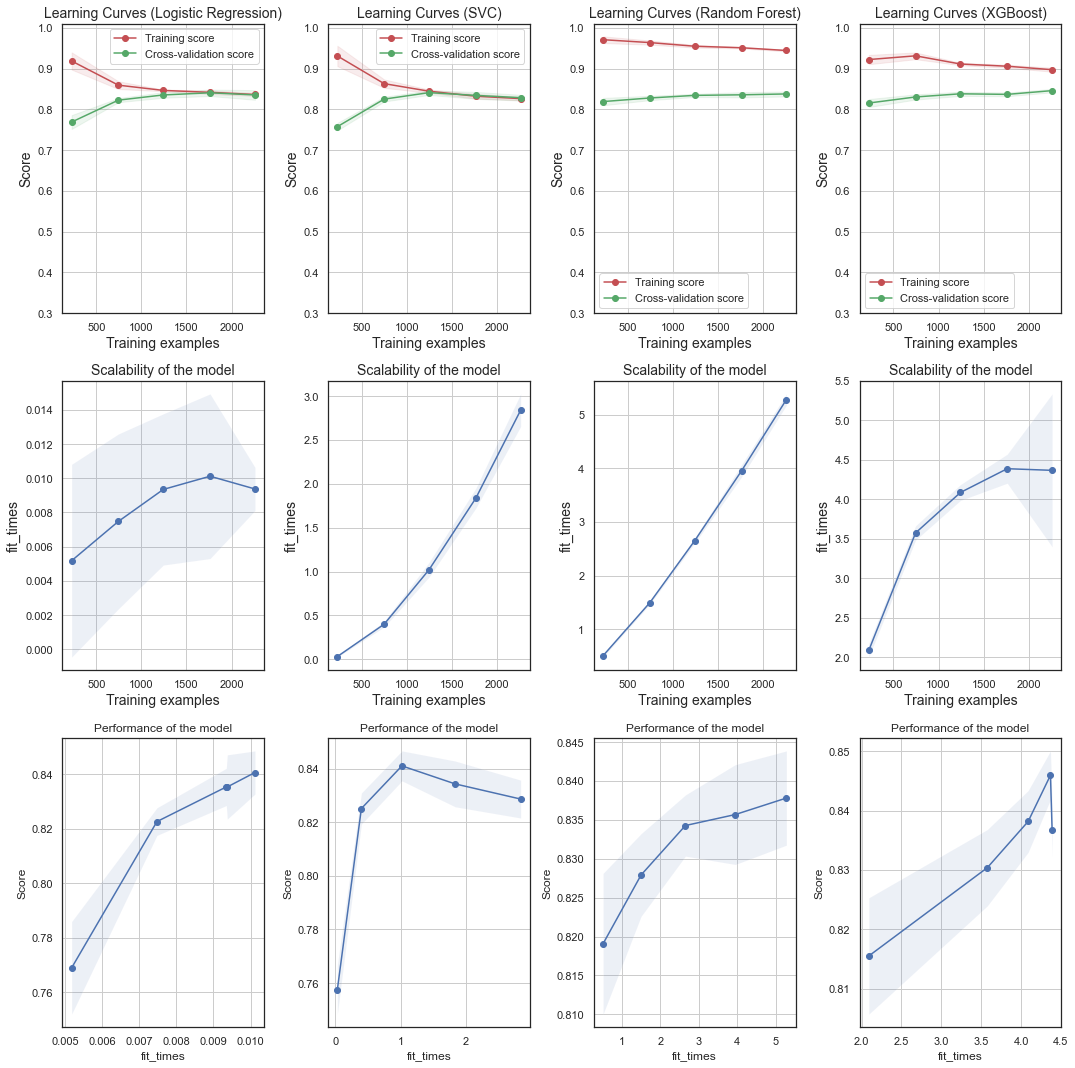

CPU times: user 1.22 s, sys: 304 ms, total: 1.53 s
Wall time: 59.6 s


In [763]:
%%time
# Plotted learning curves from the function above on Dataset 1 (PCA dimension reduction)

fig, axes = plt.subplots(3, 4, figsize=(15, 15))

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = logreg
plot_learning_curve(estimator, title, X_train_pca, y_train, axes=axes[:, 0], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (SVC)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = svc
plot_learning_curve(estimator, title, X_train_pca, y_train, axes=axes[:, 1], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = rforest
plot_learning_curve(estimator, title, X_train_pca, y_train, axes=axes[:, 2], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (XGBoost)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = xgb
plot_learning_curve(estimator, title, X_train_pca, y_train, axes=axes[:, 3], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

fig.tight_layout()
plt.show()

/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array w

/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array w

/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/.local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

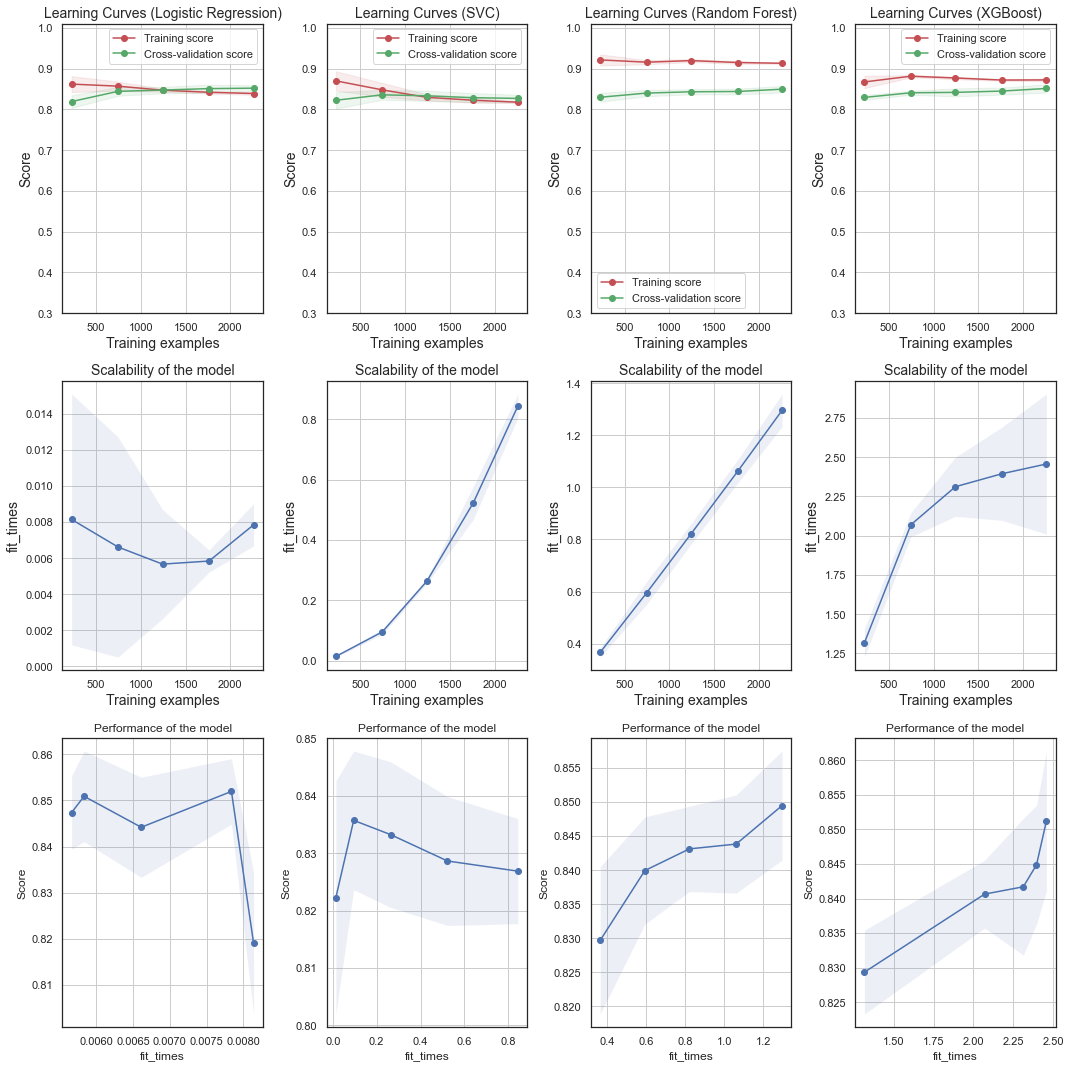

CPU times: user 1.23 s, sys: 187 ms, total: 1.41 s
Wall time: 24.4 s
[22:13:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restor

In [764]:
%%time
# Plotted learning curves from the function above on Dataset 2 (Top30 features selected by RFE)

fig, axes = plt.subplots(3, 4, figsize=(15, 15))

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = logreg
plot_learning_curve(estimator, title, X_train_top30, y_train, axes=axes[:, 0], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (SVC)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = svc
plot_learning_curve(estimator, title, X_train_top30, y_train, axes=axes[:, 1], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = rforest
plot_learning_curve(estimator, title, X_train_top30, y_train, axes=axes[:, 2], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (XGBoost)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = xgb
plot_learning_curve(estimator, title, X_train_top30, y_train, axes=axes[:, 3], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

fig.tight_layout()
plt.show()

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning,

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: Future

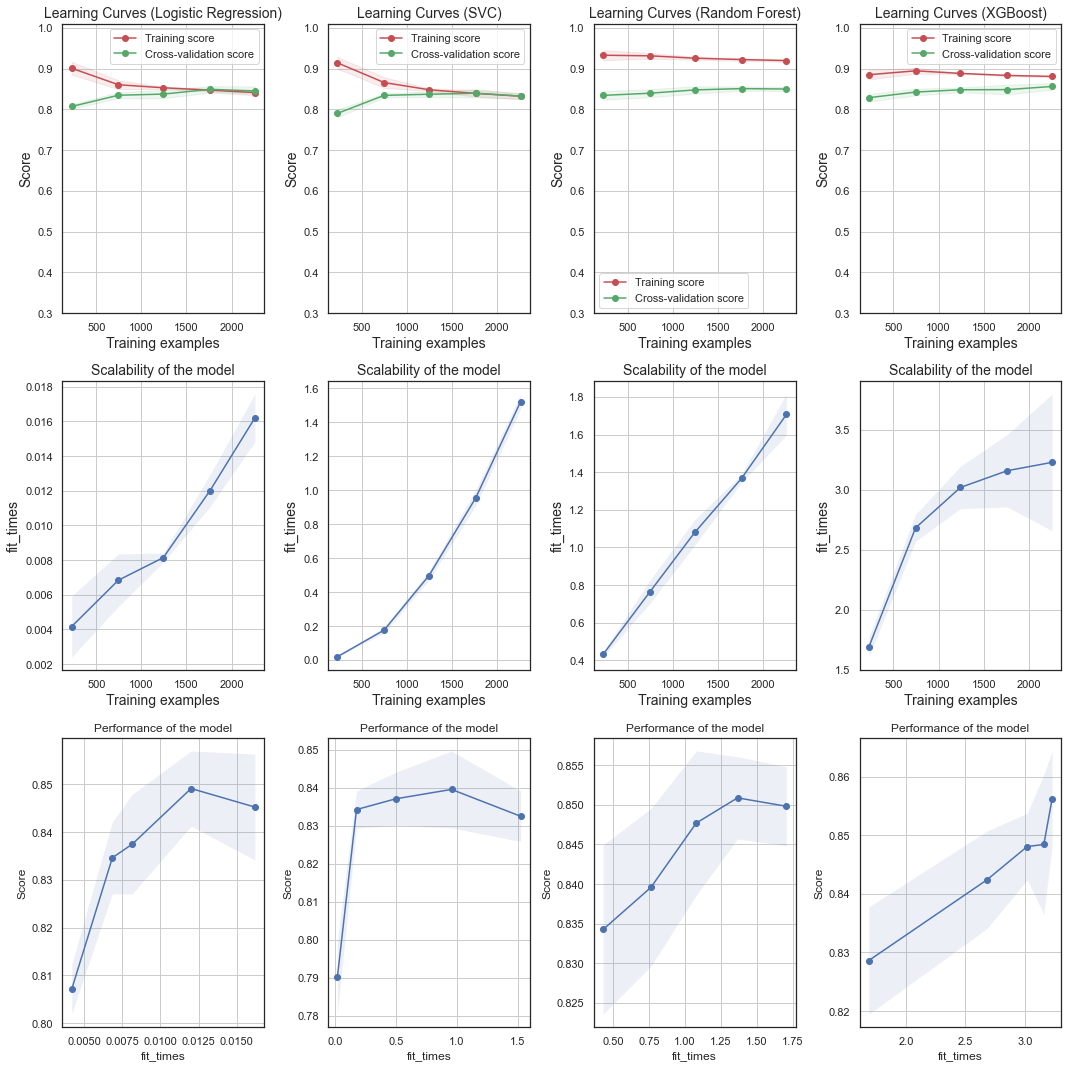

CPU times: user 1.32 s, sys: 190 ms, total: 1.51 s
Wall time: 32.7 s


In [726]:
%%time
# Plotted learning curves from the function above on Dataset 3 (Top60 features selected by RFE)

fig, axes = plt.subplots(3, 4, figsize=(15, 15))

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = logreg
plot_learning_curve(estimator, title, X_train_top60, y_train, axes=axes[:, 0], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (SVC)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = svc
plot_learning_curve(estimator, title, X_train_top60, y_train, axes=axes[:, 1], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = rforest
plot_learning_curve(estimator, title, X_train_top60, y_train, axes=axes[:, 2], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (XGBoost)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = xgb
plot_learning_curve(estimator, title, X_train_top60, y_train, axes=axes[:, 3], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

fig.tight_layout()
plt.show()

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning,

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate

/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/gaylecferguson/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: Future

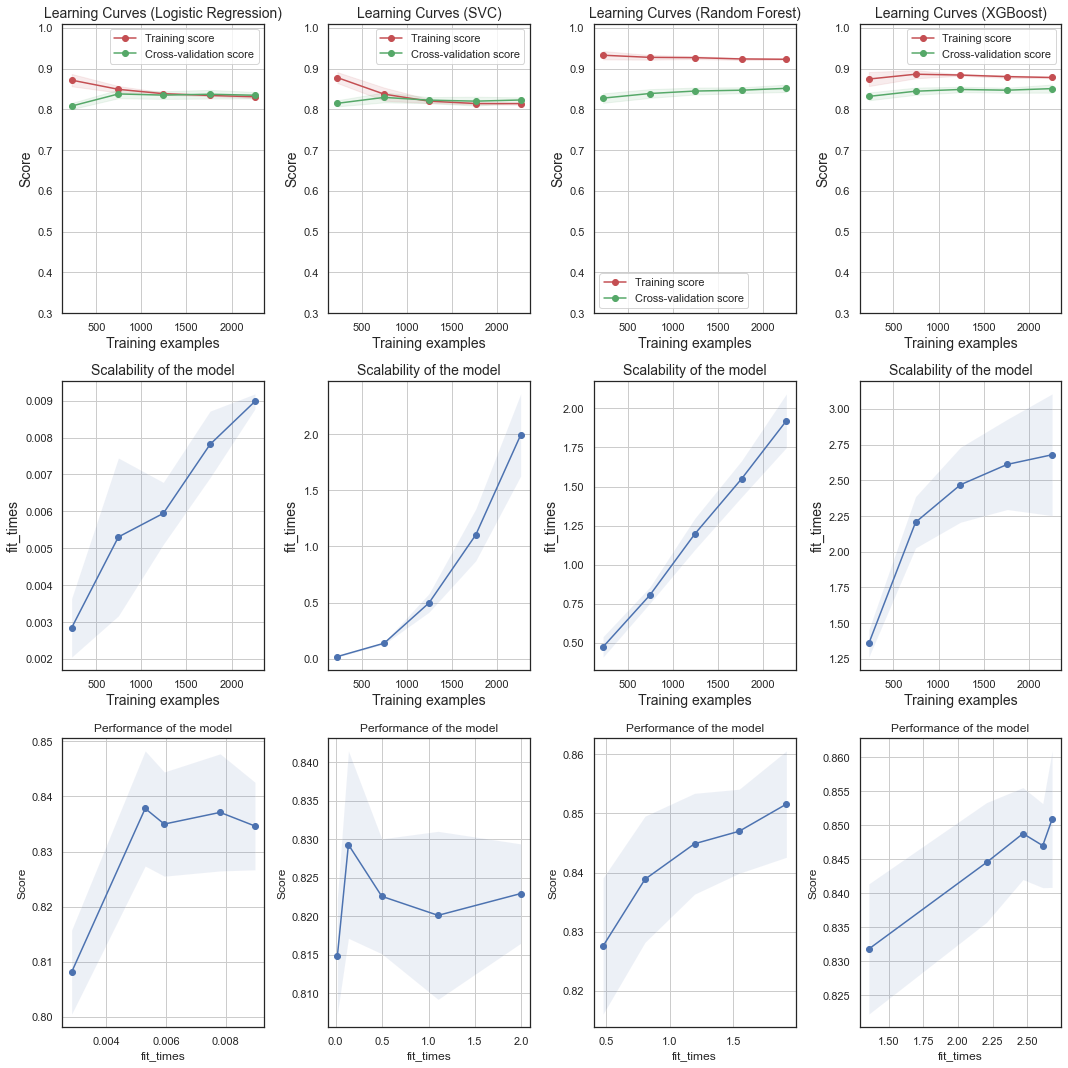

CPU times: user 1.27 s, sys: 167 ms, total: 1.44 s
Wall time: 31.2 s


In [727]:
%%time
# Plotted learning curves from the function above on Dataset 4 (Top30 features selected by SKB)

fig, axes = plt.subplots(3, 4, figsize=(15, 15))

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = logreg
plot_learning_curve(estimator, title, X_train_skb, y_train, axes=axes[:, 0], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (SVC)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = svc
plot_learning_curve(estimator, title, X_train_skb, y_train, axes=axes[:, 1], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = rforest
plot_learning_curve(estimator, title, X_train_skb, y_train, axes=axes[:, 2], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (XGBoost)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = xgb
plot_learning_curve(estimator, title, X_train_skb, y_train, axes=axes[:, 3], ylim=(0.3, 1.01), cv=cv, n_jobs=4)

fig.tight_layout()
plt.show()

### 2.5.2. Show Summary Report for the Best Models

In [728]:
%%time
# helper function to show results and charts
def show_summary_report(actual, prediction, probabilities):

    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, probabilities)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, probabilities)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

CPU times: user 14 µs, sys: 37 µs, total: 51 µs
Wall time: 52.9 µs


Baseline is 73% accuracy: if we predicted that every hospitalised person would not die (i.e. would survive) then we would be correct 73% of the time.

[20:55:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.8335 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8034 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4123 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8561                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


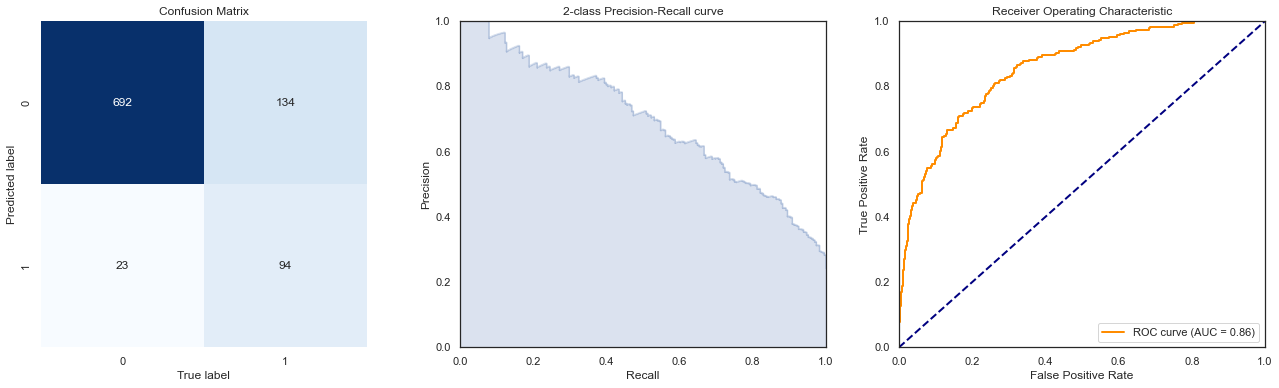

CPU times: user 10.4 s, sys: 1.36 s, total: 11.8 s
Wall time: 1.88 s


(0.8335100742311771,
 0.8034188034188035,
 0.41228070175438597,
 0.8560912771439086)

In [729]:
%%time
# Summary Report - XGBoost Classifier, Dataset_1 - PCA dimension reduction
xgb.fit(X_train_pca, y_train) 

actual = y_test.ravel()
prediction = xgb.predict(X_test_pca) 
probabilities = xgb.predict_proba(X_test_pca)[:,1]
show_summary_report(actual, prediction, probabilities)

[20:55:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.8441 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8189 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4561 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8712                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


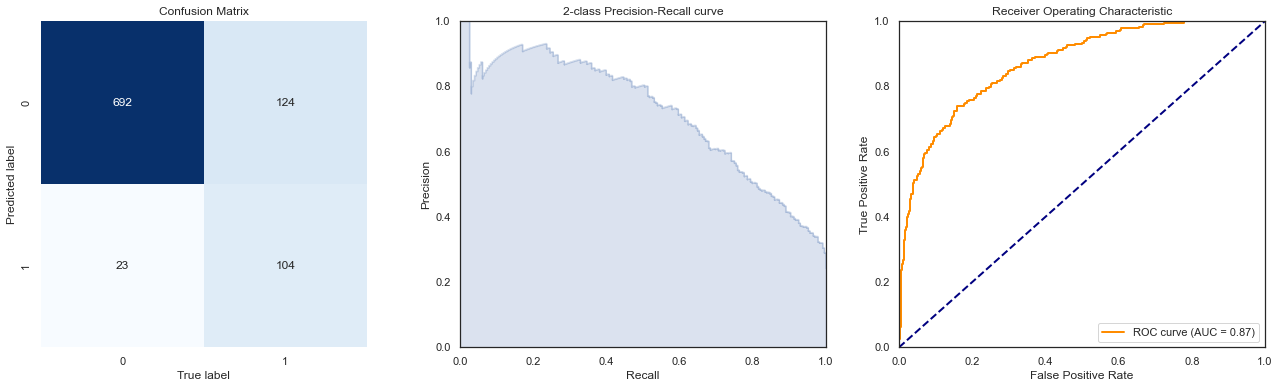

CPU times: user 5.36 s, sys: 944 ms, total: 6.31 s
Wall time: 1.01 s


(0.8441145281018028,
 0.8188976377952756,
 0.45614035087719296,
 0.8712366580787634)

In [730]:
%%time
# Summary Report - XGBoost Classifier, Dataset_2 - Top 30 Features selected by RFE
xgb.fit(X_train_top30, y_train) 

actual = y_test.ravel()
prediction = xgb.predict(X_test_top30) 
probabilities = xgb.predict_proba(X_test_top30)[:,1]
show_summary_report(actual, prediction, probabilities)

[20:55:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.8484 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8295 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4693 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8790                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


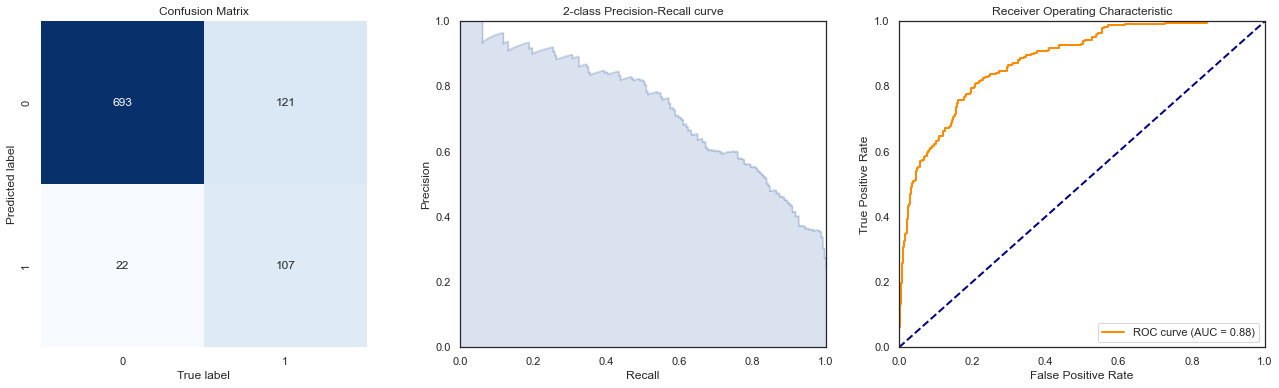

CPU times: user 6.47 s, sys: 642 ms, total: 7.11 s
Wall time: 1.03 s


(0.848356309650053, 0.8294573643410853, 0.4692982456140351, 0.8790271132376395)

In [731]:
%%time
# Summary Report - XGBoost Classifier, Dataset_3 - Top 60 Features selected by RFE
xgb.fit(X_train_top60, y_train) 

actual = y_test.ravel()
prediction = xgb.predict(X_test_top60) 
probabilities = xgb.predict_proba(X_test_top60)[:,1]
show_summary_report(actual, prediction, probabilities)

[20:55:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.8473 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8231 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4693 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8744                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


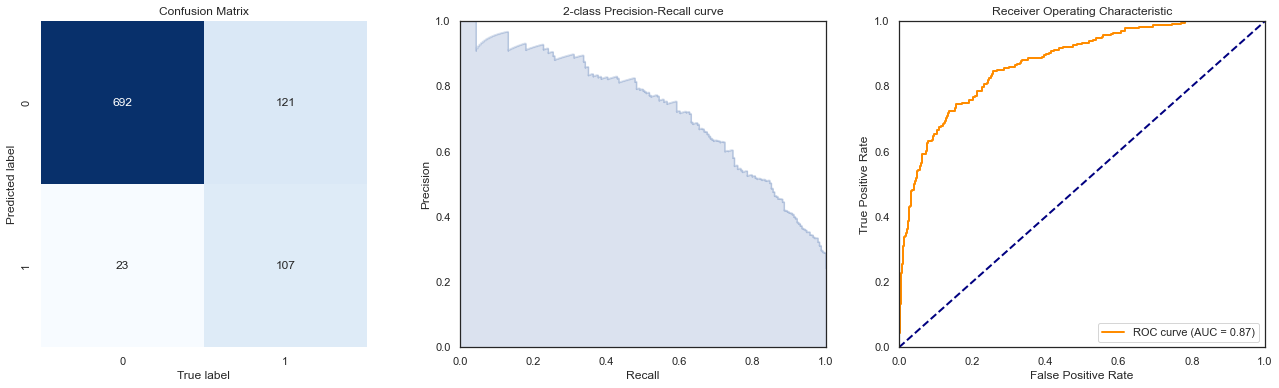

CPU times: user 4.74 s, sys: 812 ms, total: 5.55 s
Wall time: 904 ms


(0.8472958642629904, 0.823076923076923, 0.4692982456140351, 0.8743957796589376)

In [732]:
%%time
# Summary Report - XGBoost Classifier, Dataset_4 - Top 30 Features selected by SKB
xgb.fit(X_train_skb, y_train) 

actual = y_test.ravel()
prediction = xgb.predict(X_test_skb) 
probabilities = xgb.predict_proba(X_test_skb)[:,1]
show_summary_report(actual, prediction, probabilities)

Accuracy : 0.8324 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8302 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.3860 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8569                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


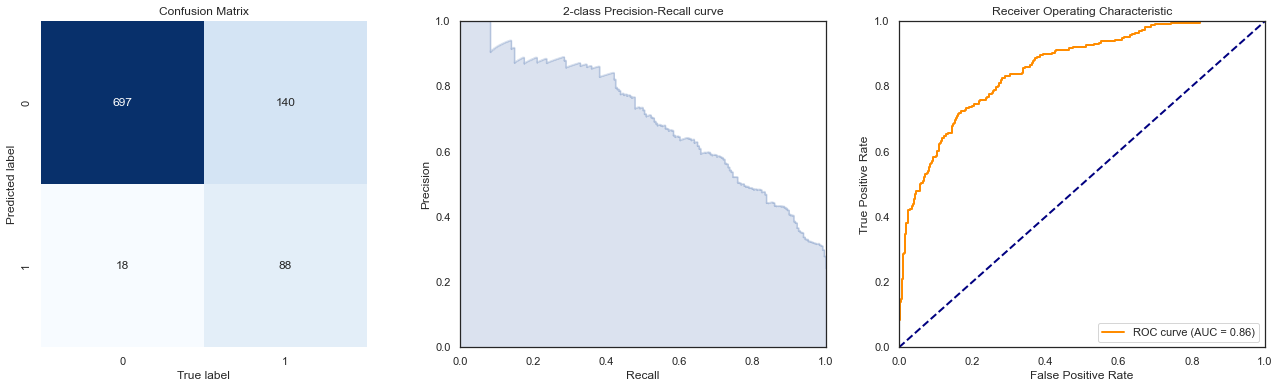

CPU times: user 6.55 s, sys: 111 ms, total: 6.66 s
Wall time: 7.08 s


(0.8324496288441146,
 0.8301886792452831,
 0.38596491228070173,
 0.8569132621764202)

In [765]:
%%time
# Summary Report - Random Forest Classifier, Dataset_1 - PCA Dimension Reduction
rforest.fit(X_train_pca, y_train) 

actual = y_test.ravel()
prediction = rforest.predict(X_test_pca) 
probabilities = rforest.predict_proba(X_test_pca)[:,1]
show_summary_report(actual, prediction, probabilities)

Accuracy : 0.8378 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8099 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4298 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8700                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


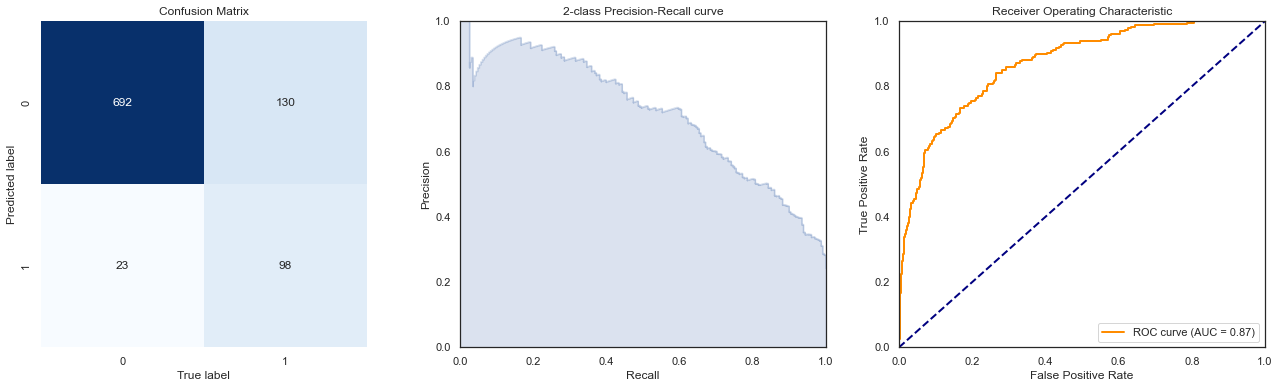

CPU times: user 1.62 s, sys: 29.9 ms, total: 1.65 s
Wall time: 1.7 s


(0.8377518557794273,
 0.8099173553719008,
 0.4298245614035088,
 0.8699791436633543)

In [766]:
%%time
# Summary Report - Random Forest Classifier, Dataset_2 - Top 30 features selected by RFE
rforest.fit(X_train_top30, y_train) 

actual = y_test.ravel()
prediction = rforest.predict(X_test_top30) 
probabilities = rforest.predict_proba(X_test_top30)[:,1]
show_summary_report(actual, prediction, probabilities)

Accuracy : 0.8388 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8115 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4342 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8748                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


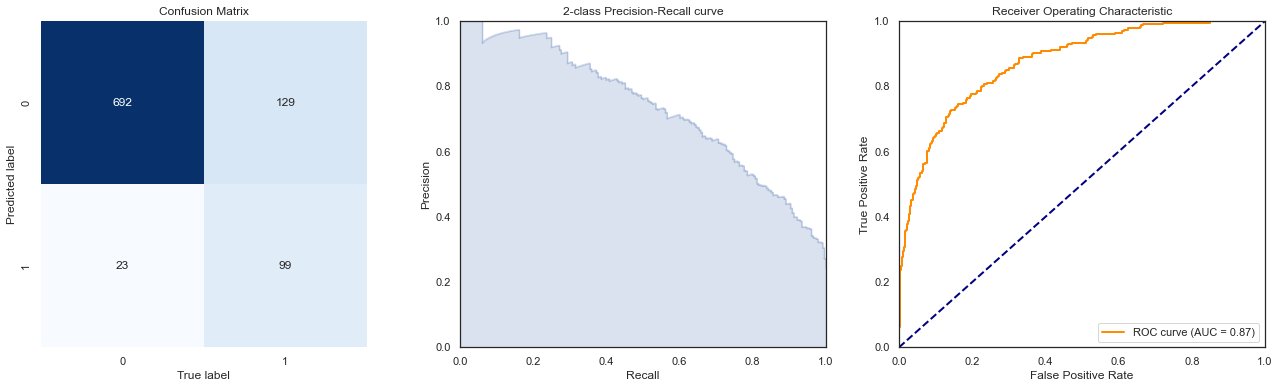

CPU times: user 1.79 s, sys: 26.5 ms, total: 1.82 s
Wall time: 1.84 s


(0.83881230116649, 0.8114754098360656, 0.4342105263157895, 0.874757698441909)

In [767]:
%%time
# Summary Report - Random Forest Classifier, Dataset_3 - Top 60 features selected by RFE
rforest.fit(X_train_top60, y_train) 

actual = y_test.ravel()
prediction = rforest.predict(X_test_top60) 
probabilities = rforest.predict_proba(X_test_top60)[:,1]
show_summary_report(actual, prediction, probabilities)

Accuracy : 0.8378 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7863 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4518 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8706                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


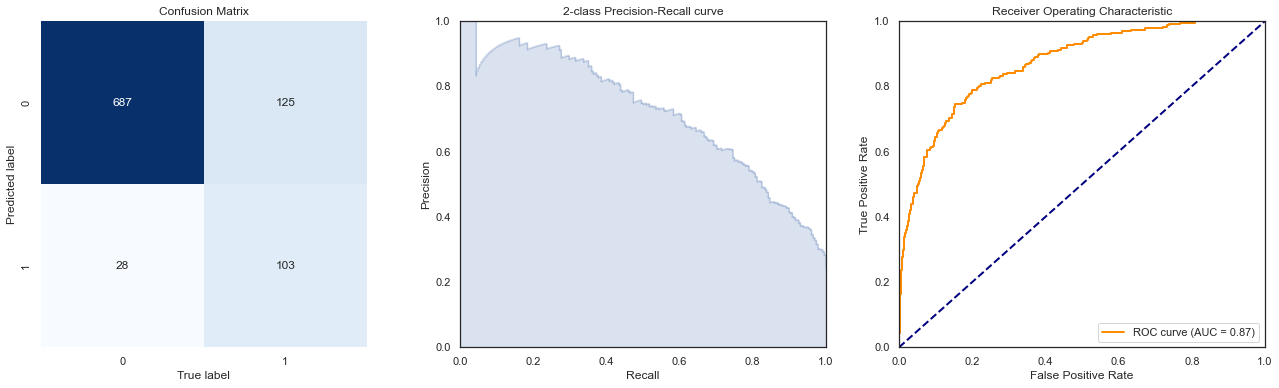

CPU times: user 1.97 s, sys: 43.9 ms, total: 2.02 s
Wall time: 2.06 s


(0.8377518557794273,
 0.7862595419847328,
 0.4517543859649123,
 0.8706293706293706)

In [768]:
%%time
# Summary Report - Random Forest Classifier, Dataset_4 - Top 30 features selected by SKB
rforest.fit(X_train_skb, y_train) 

actual = y_test.ravel()
prediction = rforest.predict(X_test_skb) 
probabilities = rforest.predict_proba(X_test_skb)[:,1]
show_summary_report(actual, prediction, probabilities)

Accuracy : 0.8261 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8636 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.3333 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8539                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


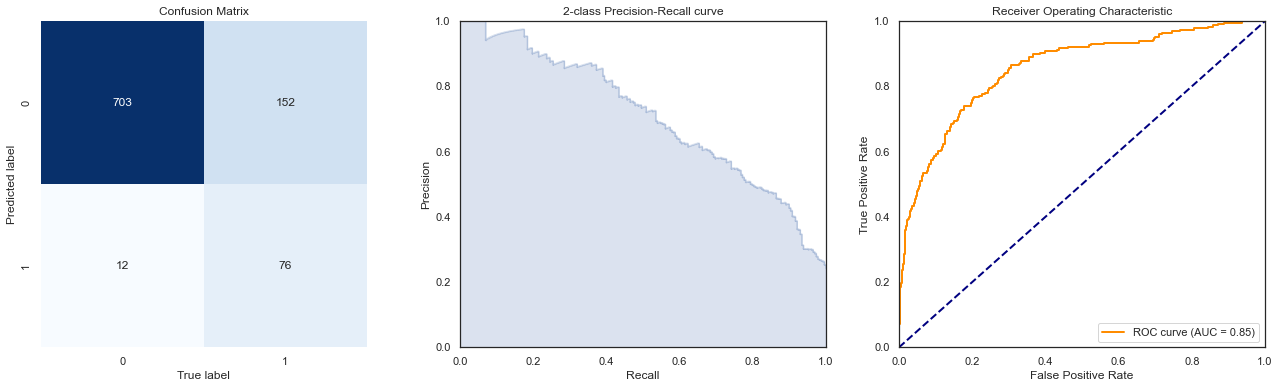

CPU times: user 3.99 s, sys: 60.1 ms, total: 4.05 s
Wall time: 4.16 s


(0.8260869565217391, 0.8636363636363636, 0.3333333333333333, 0.853870690712796)

In [769]:
%%time
# Summary Report - SVC, Dataset_1 - PCA dimension reduction
svc.fit(X_train_pca, y_train) 

actual = y_test.ravel()
prediction = svc.predict(X_test_pca) 
probabilities = svc.predict_proba(X_test_pca)[:,1]
show_summary_report(actual, prediction, probabilities)

Accuracy : 0.8176 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8500 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.2982 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8559                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


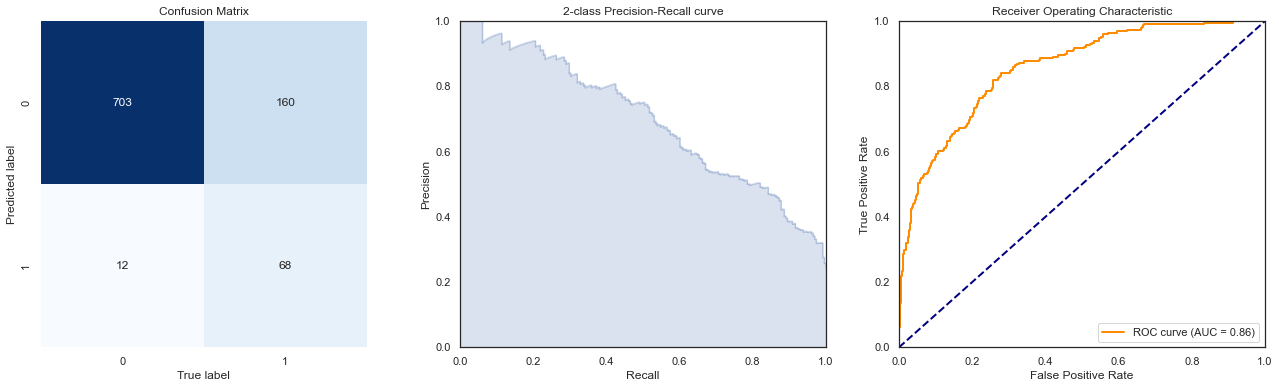

CPU times: user 1.4 s, sys: 19.9 ms, total: 1.42 s
Wall time: 1.44 s


(0.8176033934252386, 0.85, 0.2982456140350877, 0.8558827137774506)

In [770]:
%%time
# Summary Report - SVC, Dataset_2 - Top 30 features selected by RFE
svc.fit(X_train_top30, y_train) 

actual = y_test.ravel()
prediction = svc.predict(X_test_top30) 
probabilities = svc.predict_proba(X_test_top30)[:,1]
show_summary_report(actual, prediction, probabilities)

Accuracy : 0.8335 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8737 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.3640 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8517                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


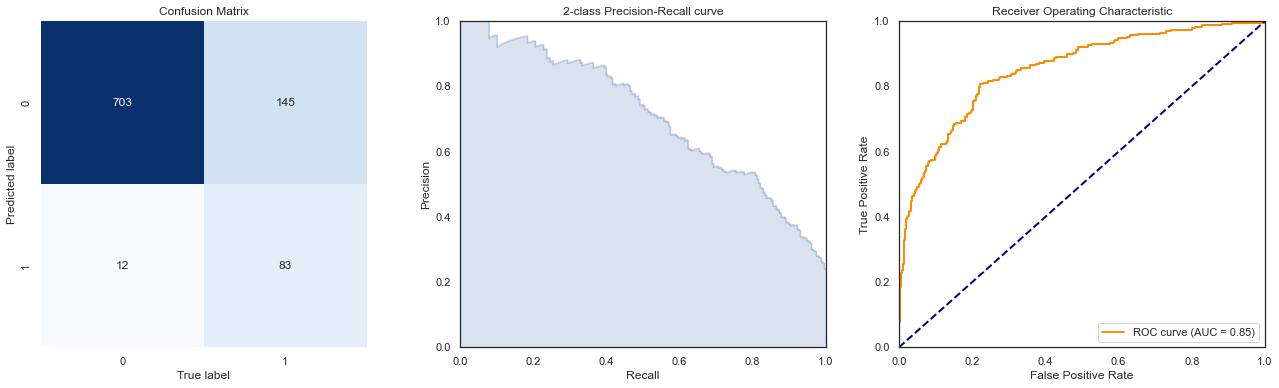

CPU times: user 1.98 s, sys: 21.6 ms, total: 2 s
Wall time: 2.02 s


(0.8335100742311771,
 0.8736842105263158,
 0.36403508771929827,
 0.8516501042816832)

In [771]:
%%time
# Summary Report - SVC, Dataset_3 - Top 60 features selected by RFE
svc.fit(X_train_top60, y_train) 

actual = y_test.ravel()
prediction = svc.predict(X_test_top60) 
probabilities = svc.predict_proba(X_test_top60)[:,1]
show_summary_report(actual, prediction, probabilities)

Accuracy : 0.8155 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8375 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.2939 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8280                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


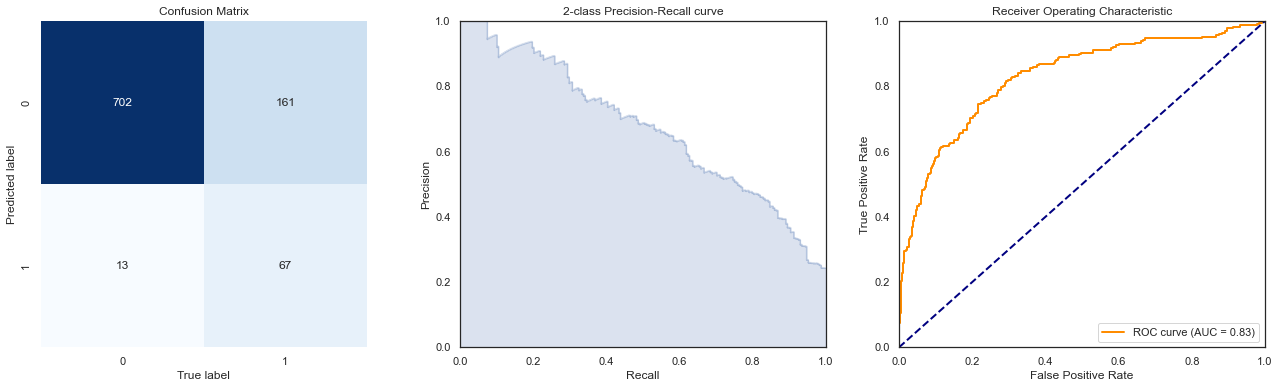

CPU times: user 2.12 s, sys: 23 ms, total: 2.14 s
Wall time: 2.15 s


(0.8154825026511134, 0.8375, 0.29385964912280704, 0.8279597595387068)

In [772]:
%%time
# Summary Report - SVC, Dataset_4 - Top 30 features selected by SKB
svc.fit(X_train_skb, y_train) 

actual = y_test.ravel()
prediction = svc.predict(X_test_skb) 
probabilities = svc.predict_proba(X_test_skb)[:,1]
show_summary_report(actual, prediction, probabilities)

In [741]:
# Exported X and y data to .csv
X_train_top60.to_csv('X_train_top60death.csv')
X_val_top60.to_csv('X_val_top60death.csv')
X_test_top60.to_csv('X_test_top60death.csv')

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)

y_train.to_csv('y_train_death.csv')
y_val.to_csv('y_val_death.csv')
y_test.to_csv('y_test_death.csv')

## 2.6. Conclusions 

The best performing models were Random Forest and XGBoost, though it should be noted that the baseline accuracy is 75.6%, i.e., predicting ‘recovery’ for every patient would result in 75.6% accuracy of the model.  The best models, therefore, perform only 6% better than the baseline. As with classifying illness severity, recursive feature elimination produced better results than the univariate method of feature selection. 

There was no evidence of overfitting for any of the models evaluated, and fitting was very rapid, indicating that the models can be scaled to much larger inputs without taking large amounts of time to fit. 

Unfortunately, the models were very poor at correctly predicting COVID-19 deaths, with recall of less than 50%. This means that more than half of the patients who died were incorrectly predicted to survive. Thus, we were unsuccessful at modelling and predicting COVID-19 deaths and do not recommend that this model be used in a clinical setting. 

Predicting COVID-19 deaths was less successful than predicting COVID-19 illness severity, with accuracy only 6% better than the baseline prediction and recall below 50%. We don’t recommend using the model to predict deaths at this stage. 